In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
import rainflow

from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

from scipy.io import savemat


In [2]:
## Added from old vrsion 


In [3]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [4]:
parameter_values.search("SEI ki")

SEI kinetic rate constant [m.s-1]	1e-12


In [5]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",        
    }
)
# spm.print_parameter_info()
param=spm.param

In [6]:
cell = 13

In [7]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")


# drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_default_5Ah.csv", comment="#", header=None).to_numpy()
# drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_default_5A_norgen10_min.csv", comment="#", header=None).to_numpy()

# drive_cycle2 = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_GM_5Ah.csv", comment="#", header=None).to_numpy()
# drive_cycle_OEM1 = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_GM_5Ah_norgen10_min.csv", comment="#", header=None).to_numpy()
Created_Drive = pd.read_csv("/Users/hamid/piibamm/PyBaMM/V2G/Created_Drive.csv", comment="#", header=None).to_numpy()
Half_Creeted_Drive = pd.read_csv("/Users/hamid/Drive Cycle/Half_hour_creeted_5Ah.csv", comment="#", header=None).to_numpy()



In [9]:
experiment13 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Creeted_Drive (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for .7 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Creeted_Drive (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 1.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1,
    drive_cycles={"Creeted_Drive": Created_Drive},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment14 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Creeted_Drive (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Creeted_Drive (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.2 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1,
    drive_cycles={"Creeted_Drive": Created_Drive},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment23 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*700,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment24 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

In [21]:
# Lowe voltages

experiment123 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.9V",
         "Hold at 3.9V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.9V",
          "Hold at 3.9V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*700,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment124 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.9V",
         "Hold at 3.9V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.9V",
          "Hold at 3.9V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

# Lowe voltages

experiment223 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.75V",
         "Hold at 3.75V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.75V",
          "Hold at 3.75V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*700,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment224 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.75V",
         "Hold at 3.75V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.75V",
          "Hold at 3.75V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

In [10]:
# AA=rainflow.extract_cycles(Half_Creeted_Drive[:,1])


In [11]:
# list(AA)

In [11]:
# parameter_values = get_parameter_values()

par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]


# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
#Using 1.5C(cell 4) and drivexyxle(cell1 9) Cost:C,LLI,Cn,Cp,x100
par_val[6]=[4.0023e-7, 2.22803e-6, 1.3446,9.82e-10]
#Using cells 13 and 19
par_val[7]=[2.2296e-7, 10.7088e-7, 1.02, 7.423e-10]



sno = 7


In [12]:
parameter_values.update(
    {
#         "Positive electrode LAM constant proportional term [s-1]":8.755e-8,   #2.5112e-07, #Using Sravan's new fit Dec27 2022
#         "Negative electrode LAM constant proportional term [s-1]":8.572e-7, #2.4741e-06,
#         "Positive electrode LAM constant exponential term":1.135, #1.1942,
#         "Negative electrode LAM constant exponential term":1.135,# 1.1942,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16, #4.60788219e-16, #,
        "EC diffusivity [m2.s-1]":8.30909086e-19,# 4.56607447e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,# 1.87422275e+04,
        
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        
        "Upper voltage cut-off [V]":4.2,
        "SEI resistivity [Ohm.m]":30000.0,
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.0,
        
    },
    check_already_exists=False,
)

In [17]:
SOC_0

1

In [18]:
# all_sumvars_dict23 = cycle_adaptive_simulation(spm, parameter_values, experiment23,SOC_0, save_at_cycles=1,drive_cycle=Half_Creeted_Drive)

2023-06-27 15:45:23.940 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (14.140 ms elapsed) --------------------
2023-06-27 15:45:23.941 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 15:45:24.205 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/14: Rest for 5 minutes
2023-06-27 15:45:24.258 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/14: Discharge at C/4 for 1 hours
2023-06-27 15:45:24.361 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/14: Rest for 5 minutes
2023-06-27 15:45:24.371 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 5/14: Charge at C/4 until 4.2V
2023-06-27 15:45:24.495 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 6/14: Hold at 4.2V for 1.5 hours
2023-06-27 15:45:24.697 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 7/14: Rest for 20 minutes
2023-06-27 15:45:24.710 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 8/14: Run Hal

SolverError: Could not find acceptable solution: solver terminated successfully, but maximum solution error (17109.824740874286) above tolerance (1e-06)

In [ ]:
# fig = plotc(all_sumvars_dict234,dfe);


In [ ]:
# all_sumvars_dict=all_sumvars_dict234
# x100=all_sumvars_dict["x_100"]
# y100=all_sumvars_dict["y_100"]
# x0=all_sumvars_dict["x_0"]
# y0=all_sumvars_dict["y_0"]
# Cap=all_sumvars_dict["Capacity [A.h]"]
# LoC_SEI_summ=all_sumvars_dict["Loss of capacity to SEI [A.h]"]
# LAM_P=all_sumvars_dict["Loss of active material in positive electrode [%]"]
# LAM_N=all_sumvars_dict["Loss of active material in negative electrode [%]"]
# C_Neg=all_sumvars_dict["C_n"]
# C_pos=all_sumvars_dict["C_p"]
# LLI=all_sumvars_dict["Loss of lithium inventory [%]"]
# LLI_mol= all_sumvars_dict["Total lithium lost [mol]"]
# LLI_Side_mol= all_sumvars_dict["Total lithium lost to side reactions [mol]"]
# LLI_plating_mol= all_sumvars_dict["Loss of lithium to lithium plating [mol]"]
# LLI_SEI_mol= all_sumvars_dict["Loss of lithium to SEI [mol]"]
# cycle_num=all_sumvars_dict["Cycle number"]

In [ ]:
# from scipy.io import savemat

# ident=""
# mdic = {
#     "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
#         "LoC_SEI_summ"+ident:LoC_SEI_summ,
#         "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
#         "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
#         "LLI_SEI_mol":LLI_SEI_mol,
#         "LLI_plating_mol":LLI_plating_mol,
#         "LLI_mol":LLI_mol,
#         "LLI_Side_mol":LLI_Side_mol
    
#        }
# savemat("Peyman__fastsim_experiment23_Jun27.mat",mdic)

In [25]:
sim_long123 = pybamm.Simulation(spm, experiment=experiment123, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))

In [26]:
sol_long123 = sim_long123.solve(initial_soc=0.55, save_at_cycles=10  )
# sol_long = sim_long.solve(save_at_cycles=1  )

2023-06-27 17:12:45.460 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1000 (15.085 ms elapsed) --------------------
2023-06-27 17:12:45.461 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:12:45.987 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:12:46.047 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 3/14: Rest for 1 hours
2023-06-27 17:12:46.105 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:12:46.111 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:12:46.232 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:12:46.793 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:12:46.816 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, s

2023-06-27 17:12:57.604 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:12:57.629 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:12:58.072 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:12:58.084 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 10/14: Rest for 1 hours
2023-06-27 17:12:58.147 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:12:58.155 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:12:58.235 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:12:58.979 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:12:59.306 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.847

2023-06-27 17:13:09.151 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:13:09.483 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.842 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:13:09.484 - [NOTICE] callbacks.on_cycle_start(174): Cycle 10/1000 (24.038 s elapsed) --------------------
2023-06-27 17:13:09.485 - [NOTICE] callbacks.on_step_start(182): Cycle 10/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:09.946 - [NOTICE] callbacks.on_step_start(182): Cycle 10/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:13:09.955 - [NOTICE] callbacks.on_step_start(182): Cycle 10/1000, step 3/14: Rest for 1 hours
2023-06-27 17:13:10.009 - [NOTICE] callbacks.on_step_start(182): Cycle 10/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:13:10.017 - [NOTICE] callbacks.on_step_start(182): Cycle 10/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:13:10.065 - [NOTICE] callbacks.on_step_start

2023-06-27 17:13:20.174 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:13:20.179 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:13:20.224 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:13:20.626 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:13:20.650 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:21.087 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:13:21.099 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 10/14: Rest for 1 hours
2023-06-27 17:13:21.155 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:13:21.162 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, s

2023-06-27 17:13:31.337 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:13:31.344 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:13:31.420 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:13:32.026 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:13:32.348 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.830 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:13:32.348 - [NOTICE] callbacks.on_cycle_start(174): Cycle 19/1000 (46.902 s elapsed) --------------------
2023-06-27 17:13:32.349 - [NOTICE] callbacks.on_step_start(182): Cycle 19/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:32.839 - [NOTICE] callbacks.on_step_start(182): Cycle 19/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:13:32.854 - [NOTICE] callback

2023-06-27 17:13:42.723 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:43.230 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:13:43.239 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 3/14: Rest for 1 hours
2023-06-27 17:13:43.300 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:13:43.308 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:13:43.358 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:13:43.756 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:13:43.781 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:44.223 - [NOTICE] callbacks.on_step_start(18

2023-06-27 17:13:56.399 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:13:56.421 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:13:56.867 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:13:56.876 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 10/14: Rest for 1 hours
2023-06-27 17:13:56.933 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:13:56.941 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:13:57.017 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:13:57.631 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:13:57.955 - [NOTICE] callbacks.on_cycle_end(196): Capacity is n

2023-06-27 17:14:07.244 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:14:07.834 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:14:08.145 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.812 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:14:08.146 - [NOTICE] callbacks.on_cycle_start(174): Cycle 32/1000 (1 minute, 23 seconds elapsed) --------------------
2023-06-27 17:14:08.147 - [NOTICE] callbacks.on_step_start(182): Cycle 32/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:14:08.583 - [NOTICE] callbacks.on_step_start(182): Cycle 32/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:14:08.593 - [NOTICE] callbacks.on_step_start(182): Cycle 32/1000, step 3/14: Rest for 1 hours
2023-06-27 17:14:08.649 - [NOTICE] callbacks.on_step_start(182): Cycle 32/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:14:08.657 - [NOTICE] callbac

2023-06-27 17:14:19.045 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 3/14: Rest for 1 hours
2023-06-27 17:14:19.103 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:14:19.109 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:14:19.157 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:14:19.605 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:14:19.631 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:14:20.089 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:14:20.102 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 10/14: Rest for 1 hours
2023-06-27 17:14:20.161 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step

2023-06-27 17:14:30.352 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:14:30.367 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 10/14: Rest for 1 hours
2023-06-27 17:14:30.428 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:14:30.436 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:14:30.518 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:14:31.113 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:14:31.432 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.799 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:14:31.433 - [NOTICE] callbacks.on_cycle_start(174): Cycle 41/1000 (1 minute, 46 seconds elapsed) --------------------
2023-06-27 17:14:31.433 - [NOTICE] callbacks.on_step_s

2023-06-27 17:14:41.903 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.794 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:14:41.903 - [NOTICE] callbacks.on_cycle_start(174): Cycle 45/1000 (1 minute, 56 seconds elapsed) --------------------
2023-06-27 17:14:41.904 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:14:42.336 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:14:42.345 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 3/14: Rest for 1 hours
2023-06-27 17:14:42.401 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:14:42.407 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:14:42.453 - [NOTICE] callbacks.on_step_start(182): Cycle 45/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:14:42.847 - [NOTICE] cal

2023-06-27 17:14:52.903 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:14:52.958 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:14:53.379 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:14:53.406 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:14:53.855 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:14:53.868 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 10/14: Rest for 1 hours
2023-06-27 17:14:53.922 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:14:53.930 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:14:54.006 - [NOTICE] callbacks.on_step_start(182): Cycle 49

2023-06-27 17:15:04.337 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:15:04.344 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:15:04.429 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:15:05.139 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:15:05.583 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.781 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:15:05.584 - [NOTICE] callbacks.on_cycle_start(174): Cycle 54/1000 (2 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:15:05.585 - [NOTICE] callbacks.on_step_start(182): Cycle 54/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:06.078 - [NOTICE] callbacks.on_step_start(182): Cycle 54/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:15:06.088 - [NOT

2023-06-27 17:15:15.960 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:16.418 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:15:16.427 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 3/14: Rest for 1 hours
2023-06-27 17:15:16.481 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:15:16.489 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:15:16.541 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:15:16.933 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:15:16.958 - [NOTICE] callbacks.on_step_start(182): Cycle 58/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:17.384 - [NOTICE] callbacks.on_step_start(18

2023-06-27 17:15:27.013 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:15:27.040 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:27.473 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:15:27.482 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 10/14: Rest for 1 hours
2023-06-27 17:15:27.540 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:15:27.548 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:15:27.626 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:15:28.278 - [NOTICE] callbacks.on_step_start(182): Cycle 62/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:15:28.597 - [NOTICE] callbacks.on_cycle_end(196): Capacity is n

2023-06-27 17:15:37.834 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:15:38.431 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:15:38.760 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.763 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:15:38.761 - [NOTICE] callbacks.on_cycle_start(174): Cycle 67/1000 (2 minutes, 53 seconds elapsed) --------------------
2023-06-27 17:15:38.762 - [NOTICE] callbacks.on_step_start(182): Cycle 67/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:39.256 - [NOTICE] callbacks.on_step_start(182): Cycle 67/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:15:39.267 - [NOTICE] callbacks.on_step_start(182): Cycle 67/1000, step 3/14: Rest for 1 hours
2023-06-27 17:15:39.329 - [NOTICE] callbacks.on_step_start(182): Cycle 67/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:15:39.337 - [NOTICE] callba

2023-06-27 17:15:49.520 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 3/14: Rest for 1 hours
2023-06-27 17:15:49.577 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:15:49.585 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:15:49.636 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:15:50.034 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:15:50.056 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:15:50.520 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:15:50.531 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step 10/14: Rest for 1 hours
2023-06-27 17:15:50.585 - [NOTICE] callbacks.on_step_start(182): Cycle 71/1000, step

2023-06-27 17:16:01.202 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:16:01.213 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 10/14: Rest for 1 hours
2023-06-27 17:16:01.271 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:16:01.277 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:16:01.361 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:16:02.002 - [NOTICE] callbacks.on_step_start(182): Cycle 75/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:16:02.395 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.750 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:16:02.396 - [NOTICE] callbacks.on_cycle_start(174): Cycle 76/1000 (3 minutes, 17 seconds elapsed) --------------------
2023-06-27 17:16:02.397 - [NOTICE] callbacks.on_step_

2023-06-27 17:16:13.215 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.744 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:16:13.215 - [NOTICE] callbacks.on_cycle_start(174): Cycle 80/1000 (3 minutes, 28 seconds elapsed) --------------------
2023-06-27 17:16:13.217 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:13.752 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:16:13.762 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 3/14: Rest for 1 hours
2023-06-27 17:16:13.816 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:16:13.823 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:16:13.870 - [NOTICE] callbacks.on_step_start(182): Cycle 80/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:16:14.271 - [NOTICE] ca

2023-06-27 17:16:26.125 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:16:26.174 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:16:26.578 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:16:26.601 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:27.036 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:16:27.046 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 10/14: Rest for 1 hours
2023-06-27 17:16:27.102 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:16:27.109 - [NOTICE] callbacks.on_step_start(182): Cycle 84/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:16:27.180 - [NOTICE] callbacks.on_step_start(182): Cycle 84

2023-06-27 17:16:36.912 - [NOTICE] callbacks.on_step_start(182): Cycle 88/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:16:36.921 - [NOTICE] callbacks.on_step_start(182): Cycle 88/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:16:36.995 - [NOTICE] callbacks.on_step_start(182): Cycle 88/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:16:37.574 - [NOTICE] callbacks.on_step_start(182): Cycle 88/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:16:37.876 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.731 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:16:37.877 - [NOTICE] callbacks.on_cycle_start(174): Cycle 89/1000 (3 minutes, 52 seconds elapsed) --------------------
2023-06-27 17:16:37.878 - [NOTICE] callbacks.on_step_start(182): Cycle 89/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:38.312 - [NOTICE] callbacks.on_step_start(182): Cycle 89/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:16:38.323 - [NOT

2023-06-27 17:16:47.759 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:48.199 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:16:48.210 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 3/14: Rest for 1 hours
2023-06-27 17:16:48.267 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:16:48.275 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:16:48.320 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:16:48.724 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:16:48.753 - [NOTICE] callbacks.on_step_start(182): Cycle 93/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:49.269 - [NOTICE] callbacks.on_step_start(18

2023-06-27 17:16:59.100 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:16:59.125 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:16:59.590 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:16:59.600 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 10/14: Rest for 1 hours
2023-06-27 17:16:59.659 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:16:59.667 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:16:59.757 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:17:00.389 - [NOTICE] callbacks.on_step_start(182): Cycle 97/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:17:00.730 - [NOTICE] callbacks.on_cycle_end(196): Capacity is n

2023-06-27 17:17:09.941 - [NOTICE] callbacks.on_step_start(182): Cycle 101/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:17:10.530 - [NOTICE] callbacks.on_step_start(182): Cycle 101/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:17:10.845 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.713 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:17:10.846 - [NOTICE] callbacks.on_cycle_start(174): Cycle 102/1000 (4 minutes, 25 seconds elapsed) --------------------
2023-06-27 17:17:10.847 - [NOTICE] callbacks.on_step_start(182): Cycle 102/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:17:11.294 - [NOTICE] callbacks.on_step_start(182): Cycle 102/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:17:11.303 - [NOTICE] callbacks.on_step_start(182): Cycle 102/1000, step 3/14: Rest for 1 hours
2023-06-27 17:17:11.361 - [NOTICE] callbacks.on_step_start(182): Cycle 102/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:17:11.367 - [NOTICE]

2023-06-27 17:17:21.151 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:17:21.161 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 3/14: Rest for 1 hours
2023-06-27 17:17:21.212 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:17:21.218 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:17:21.261 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:17:21.657 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:17:21.683 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:17:22.109 - [NOTICE] callbacks.on_step_start(182): Cycle 106/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:17:22.122 - [NOTICE] callbacks.on_step_start(182): Cycle 106/

2023-06-27 17:17:31.665 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:17:32.079 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:17:32.093 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 10/14: Rest for 1 hours
2023-06-27 17:17:32.148 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:17:32.156 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:17:32.233 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:17:32.807 - [NOTICE] callbacks.on_step_start(182): Cycle 110/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:17:33.118 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.699 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:17:33.118 - [NOTICE] callbacks.on

2023-06-27 17:17:42.727 - [NOTICE] callbacks.on_step_start(182): Cycle 114/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:17:43.039 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.694 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:17:43.040 - [NOTICE] callbacks.on_cycle_start(174): Cycle 115/1000 (4 minutes, 58 seconds elapsed) --------------------
2023-06-27 17:17:43.040 - [NOTICE] callbacks.on_step_start(182): Cycle 115/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:17:43.475 - [NOTICE] callbacks.on_step_start(182): Cycle 115/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:17:43.484 - [NOTICE] callbacks.on_step_start(182): Cycle 115/1000, step 3/14: Rest for 1 hours
2023-06-27 17:17:43.540 - [NOTICE] callbacks.on_step_start(182): Cycle 115/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:17:43.547 - [NOTICE] callbacks.on_step_start(182): Cycle 115/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:17:43.592 - [NOTICE] ca

2023-06-27 17:17:53.276 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 3/14: Rest for 1 hours
2023-06-27 17:17:53.330 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:17:53.336 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:17:53.381 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:17:53.761 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:17:53.785 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:17:54.209 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:17:54.222 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1000, step 10/14: Rest for 1 hours
2023-06-27 17:17:54.279 - [NOTICE] callbacks.on_step_start(182): Cycle 119/1

2023-06-27 17:18:03.978 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:18:03.987 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 10/14: Rest for 1 hours
2023-06-27 17:18:04.046 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:18:04.053 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:18:04.131 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:18:04.708 - [NOTICE] callbacks.on_step_start(182): Cycle 123/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:18:05.014 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.681 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:18:05.015 - [NOTICE] callbacks.on_cycle_start(174): Cycle 124/1000 (5 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:18:05.015 - [NOTICE] callbacks.o

2023-06-27 17:18:14.779 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.675 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:18:14.780 - [NOTICE] callbacks.on_cycle_start(174): Cycle 128/1000 (5 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:18:14.780 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:18:15.214 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:18:15.224 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 3/14: Rest for 1 hours
2023-06-27 17:18:15.294 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:18:15.302 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:18:15.351 - [NOTICE] callbacks.on_step_start(182): Cycle 128/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:18:15.740 - [NOT

2023-06-27 17:18:25.223 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:18:25.229 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:18:25.271 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:18:25.672 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:18:25.698 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:18:26.135 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:18:26.146 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 10/14: Rest for 1 hours
2023-06-27 17:18:26.202 - [NOTICE] callbacks.on_step_start(182): Cycle 132/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:18:26.208 - [NOTICE] callbacks.on_step_start(182): Cycle 13

2023-06-27 17:18:36.271 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:18:36.283 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 10/14: Rest for 1 hours
2023-06-27 17:18:36.342 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:18:36.351 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:18:36.446 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:18:37.122 - [NOTICE] callbacks.on_step_start(182): Cycle 136/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:18:37.549 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.662 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:18:37.549 - [NOTICE] callbacks.on_cycle_start(174): Cycle 137/1000 (5 minutes, 52 seconds elapsed) --------------------
2023-06-27 17:18:37.550 - [NOTICE] callbacks.o

2023-06-27 17:18:50.303 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.656 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:18:50.303 - [NOTICE] callbacks.on_cycle_start(174): Cycle 141/1000 (6 minutes, 5 seconds elapsed) --------------------
2023-06-27 17:18:50.304 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:18:50.769 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:18:50.779 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 3/14: Rest for 1 hours
2023-06-27 17:18:50.835 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:18:50.842 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:18:50.886 - [NOTICE] callbacks.on_step_start(182): Cycle 141/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:18:51.289 - [NOTI

2023-06-27 17:19:00.944 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:19:00.950 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:19:00.995 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:19:01.401 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:19:01.428 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:19:01.873 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:19:01.885 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 10/14: Rest for 1 hours
2023-06-27 17:19:01.941 - [NOTICE] callbacks.on_step_start(182): Cycle 145/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:19:01.948 - [NOTICE] callbacks.on_step_start(182): Cycle 14

2023-06-27 17:19:12.676 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:19:12.688 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 10/14: Rest for 1 hours
2023-06-27 17:19:12.750 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:19:12.757 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:19:12.831 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:19:13.421 - [NOTICE] callbacks.on_step_start(182): Cycle 149/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:19:13.746 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.642 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:19:13.747 - [NOTICE] callbacks.on_cycle_start(174): Cycle 150/1000 (6 minutes, 28 seconds elapsed) --------------------
2023-06-27 17:19:13.747 - [NOTICE] callbacks.o

2023-06-27 17:19:24.164 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.637 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:19:24.164 - [NOTICE] callbacks.on_cycle_start(174): Cycle 154/1000 (6 minutes, 39 seconds elapsed) --------------------
2023-06-27 17:19:24.165 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:19:24.634 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:19:24.646 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 3/14: Rest for 1 hours
2023-06-27 17:19:24.706 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:19:24.714 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:19:24.762 - [NOTICE] callbacks.on_step_start(182): Cycle 154/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:19:25.182 - [NOT

2023-06-27 17:19:35.013 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:19:35.019 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:19:35.074 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:19:35.528 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:19:35.549 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:19:35.993 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:19:36.005 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 10/14: Rest for 1 hours
2023-06-27 17:19:36.065 - [NOTICE] callbacks.on_step_start(182): Cycle 158/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:19:36.072 - [NOTICE] callbacks.on_step_start(182): Cycle 15

2023-06-27 17:19:46.611 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:19:46.625 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 10/14: Rest for 1 hours
2023-06-27 17:19:46.692 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:19:46.699 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:19:46.784 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:19:47.384 - [NOTICE] callbacks.on_step_start(182): Cycle 162/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:19:47.718 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.623 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:19:47.719 - [NOTICE] callbacks.on_cycle_start(174): Cycle 163/1000 (7 minutes, 2 seconds elapsed) --------------------
2023-06-27 17:19:47.719 - [NOTICE] callbacks.on

2023-06-27 17:19:57.953 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.617 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:19:57.954 - [NOTICE] callbacks.on_cycle_start(174): Cycle 167/1000 (7 minutes, 12 seconds elapsed) --------------------
2023-06-27 17:19:57.955 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:19:58.404 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:19:58.414 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 3/14: Rest for 1 hours
2023-06-27 17:19:58.470 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:19:58.477 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:19:58.524 - [NOTICE] callbacks.on_step_start(182): Cycle 167/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:19:58.930 - [NOT

2023-06-27 17:20:08.490 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:20:08.497 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:20:08.545 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:20:08.961 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:20:08.985 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:20:09.435 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:20:09.447 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 10/14: Rest for 1 hours
2023-06-27 17:20:09.505 - [NOTICE] callbacks.on_step_start(182): Cycle 171/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:20:09.514 - [NOTICE] callbacks.on_step_start(182): Cycle 17

2023-06-27 17:20:19.542 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:20:19.554 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 10/14: Rest for 1 hours
2023-06-27 17:20:19.613 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:20:19.619 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:20:19.695 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:20:20.289 - [NOTICE] callbacks.on_step_start(182): Cycle 175/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:20:20.609 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.604 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:20:20.610 - [NOTICE] callbacks.on_cycle_start(174): Cycle 176/1000 (7 minutes, 35 seconds elapsed) --------------------
2023-06-27 17:20:20.611 - [NOTICE] callbacks.o

2023-06-27 17:20:30.869 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.598 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:20:30.869 - [NOTICE] callbacks.on_cycle_start(174): Cycle 180/1000 (7 minutes, 45 seconds elapsed) --------------------
2023-06-27 17:20:30.870 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:20:31.404 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:20:31.413 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 3/14: Rest for 1 hours
2023-06-27 17:20:31.472 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:20:31.481 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:20:31.555 - [NOTICE] callbacks.on_step_start(182): Cycle 180/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:20:31.969 - [NOT

2023-06-27 17:20:42.331 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:20:42.337 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:20:42.387 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:20:42.802 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:20:42.823 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:20:43.274 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:20:43.294 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 10/14: Rest for 1 hours
2023-06-27 17:20:43.353 - [NOTICE] callbacks.on_step_start(182): Cycle 184/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:20:43.359 - [NOTICE] callbacks.on_step_start(182): Cycle 18

2023-06-27 17:20:53.586 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:20:53.600 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 10/14: Rest for 1 hours
2023-06-27 17:20:53.655 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:20:53.662 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:20:53.734 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:20:54.337 - [NOTICE] callbacks.on_step_start(182): Cycle 188/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:20:54.649 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.585 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:20:54.650 - [NOTICE] callbacks.on_cycle_start(174): Cycle 189/1000 (8 minutes, 9 seconds elapsed) --------------------
2023-06-27 17:20:54.650 - [NOTICE] callbacks.on

2023-06-27 17:21:05.182 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.579 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:21:05.182 - [NOTICE] callbacks.on_cycle_start(174): Cycle 193/1000 (8 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:21:05.183 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:21:05.632 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:21:05.642 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 3/14: Rest for 1 hours
2023-06-27 17:21:05.698 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:21:05.707 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:21:05.759 - [NOTICE] callbacks.on_step_start(182): Cycle 193/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:21:06.162 - [NOT

2023-06-27 17:21:16.138 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:21:16.146 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:21:16.204 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:21:16.683 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:21:16.707 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:21:17.201 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:21:17.212 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 10/14: Rest for 1 hours
2023-06-27 17:21:17.268 - [NOTICE] callbacks.on_step_start(182): Cycle 197/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:21:17.274 - [NOTICE] callbacks.on_step_start(182): Cycle 19

2023-06-27 17:21:29.970 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:21:29.983 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 10/14: Rest for 1 hours
2023-06-27 17:21:30.043 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:21:30.053 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:21:30.132 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:21:30.744 - [NOTICE] callbacks.on_step_start(182): Cycle 201/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:21:31.056 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.565 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:21:31.057 - [NOTICE] callbacks.on_cycle_start(174): Cycle 202/1000 (8 minutes, 46 seconds elapsed) --------------------
2023-06-27 17:21:31.058 - [NOTICE] callbacks.o

2023-06-27 17:21:41.603 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.559 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:21:41.603 - [NOTICE] callbacks.on_cycle_start(174): Cycle 206/1000 (8 minutes, 56 seconds elapsed) --------------------
2023-06-27 17:21:41.604 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:21:42.062 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:21:42.072 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 3/14: Rest for 1 hours
2023-06-27 17:21:42.135 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:21:42.141 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:21:42.189 - [NOTICE] callbacks.on_step_start(182): Cycle 206/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:21:42.607 - [NOT

2023-06-27 17:21:52.898 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:21:52.905 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:21:52.954 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:21:53.366 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:21:53.391 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:21:53.812 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:21:53.823 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 10/14: Rest for 1 hours
2023-06-27 17:21:53.879 - [NOTICE] callbacks.on_step_start(182): Cycle 210/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:21:53.887 - [NOTICE] callbacks.on_step_start(182): Cycle 21

2023-06-27 17:22:04.279 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:22:04.292 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 10/14: Rest for 1 hours
2023-06-27 17:22:04.351 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:22:04.359 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:22:04.434 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:22:05.047 - [NOTICE] callbacks.on_step_start(182): Cycle 214/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:22:05.360 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.546 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:22:05.361 - [NOTICE] callbacks.on_cycle_start(174): Cycle 215/1000 (9 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:22:05.361 - [NOTICE] callbacks.o

2023-06-27 17:22:16.177 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.540 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:22:16.178 - [NOTICE] callbacks.on_cycle_start(174): Cycle 219/1000 (9 minutes, 31 seconds elapsed) --------------------
2023-06-27 17:22:16.179 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:22:16.751 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:22:16.762 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 3/14: Rest for 1 hours
2023-06-27 17:22:16.822 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:22:16.829 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:22:16.879 - [NOTICE] callbacks.on_step_start(182): Cycle 219/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:22:17.298 - [NOT

2023-06-27 17:22:27.217 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:22:27.224 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:22:27.272 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:22:27.686 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:22:27.713 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:22:28.239 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:22:28.254 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 10/14: Rest for 1 hours
2023-06-27 17:22:28.325 - [NOTICE] callbacks.on_step_start(182): Cycle 223/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:22:28.332 - [NOTICE] callbacks.on_step_start(182): Cycle 22

2023-06-27 17:22:39.098 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:22:39.110 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 10/14: Rest for 1 hours
2023-06-27 17:22:39.174 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:22:39.182 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:22:39.267 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:22:39.918 - [NOTICE] callbacks.on_step_start(182): Cycle 227/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:22:40.233 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.526 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:22:40.234 - [NOTICE] callbacks.on_cycle_start(174): Cycle 228/1000 (9 minutes, 55 seconds elapsed) --------------------
2023-06-27 17:22:40.234 - [NOTICE] callbacks.o

2023-06-27 17:22:50.416 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.521 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:22:50.417 - [NOTICE] callbacks.on_cycle_start(174): Cycle 232/1000 (10 minutes, 5 seconds elapsed) --------------------
2023-06-27 17:22:50.417 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:22:50.869 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:22:50.879 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 3/14: Rest for 1 hours
2023-06-27 17:22:50.942 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:22:50.949 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:22:50.994 - [NOTICE] callbacks.on_step_start(182): Cycle 232/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:22:51.390 - [NOT

2023-06-27 17:23:01.717 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:23:01.725 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:23:01.768 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:23:02.195 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:23:02.221 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:23:02.750 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:23:02.760 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 10/14: Rest for 1 hours
2023-06-27 17:23:02.814 - [NOTICE] callbacks.on_step_start(182): Cycle 236/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:23:02.820 - [NOTICE] callbacks.on_step_start(182): Cycle 23

2023-06-27 17:23:13.600 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:23:13.613 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 10/14: Rest for 1 hours
2023-06-27 17:23:13.673 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:23:13.680 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:23:13.760 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:23:14.359 - [NOTICE] callbacks.on_step_start(182): Cycle 240/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:23:14.687 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.507 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:23:14.687 - [NOTICE] callbacks.on_cycle_start(174): Cycle 241/1000 (10 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:23:14.688 - [NOTICE] callbacks.

2023-06-27 17:23:24.870 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.501 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:23:24.870 - [NOTICE] callbacks.on_cycle_start(174): Cycle 245/1000 (10 minutes, 39 seconds elapsed) --------------------
2023-06-27 17:23:24.871 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:23:25.301 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:23:25.313 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 3/14: Rest for 1 hours
2023-06-27 17:23:25.367 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:23:25.375 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:23:25.418 - [NOTICE] callbacks.on_step_start(182): Cycle 245/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:23:25.804 - [NO

2023-06-27 17:23:35.517 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:23:35.525 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:23:35.575 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:23:36.014 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:23:36.036 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:23:36.533 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:23:36.545 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 10/14: Rest for 1 hours
2023-06-27 17:23:36.615 - [NOTICE] callbacks.on_step_start(182): Cycle 249/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:23:36.624 - [NOTICE] callbacks.on_step_start(182): Cycle 24

2023-06-27 17:23:46.818 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:23:46.830 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 10/14: Rest for 1 hours
2023-06-27 17:23:46.887 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:23:46.895 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:23:46.972 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:23:47.673 - [NOTICE] callbacks.on_step_start(182): Cycle 253/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:23:47.999 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.488 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:23:47.999 - [NOTICE] callbacks.on_cycle_start(174): Cycle 254/1000 (11 minutes, 3 seconds elapsed) --------------------
2023-06-27 17:23:48.000 - [NOTICE] callbacks.o

2023-06-27 17:23:58.268 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.482 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:23:58.269 - [NOTICE] callbacks.on_cycle_start(174): Cycle 258/1000 (11 minutes, 13 seconds elapsed) --------------------
2023-06-27 17:23:58.270 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:23:58.729 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:23:58.739 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 3/14: Rest for 1 hours
2023-06-27 17:23:58.790 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:23:58.797 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:23:58.840 - [NOTICE] callbacks.on_step_start(182): Cycle 258/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:23:59.227 - [NO

2023-06-27 17:24:11.235 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:24:11.242 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:24:11.282 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:24:11.710 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:24:11.733 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:24:12.151 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:24:12.163 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 10/14: Rest for 1 hours
2023-06-27 17:24:12.215 - [NOTICE] callbacks.on_step_start(182): Cycle 262/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:24:12.221 - [NOTICE] callbacks.on_step_start(182): Cycle 26

2023-06-27 17:24:22.215 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:24:22.227 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 10/14: Rest for 1 hours
2023-06-27 17:24:22.289 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:24:22.296 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:24:22.377 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:24:23.001 - [NOTICE] callbacks.on_step_start(182): Cycle 266/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:24:23.348 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.468 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:24:23.348 - [NOTICE] callbacks.on_cycle_start(174): Cycle 267/1000 (11 minutes, 38 seconds elapsed) --------------------
2023-06-27 17:24:23.349 - [NOTICE] callbacks.

2023-06-27 17:24:33.724 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.462 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:24:33.724 - [NOTICE] callbacks.on_cycle_start(174): Cycle 271/1000 (11 minutes, 48 seconds elapsed) --------------------
2023-06-27 17:24:33.725 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:24:34.181 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:24:34.190 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 3/14: Rest for 1 hours
2023-06-27 17:24:34.246 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:24:34.252 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:24:34.293 - [NOTICE] callbacks.on_step_start(182): Cycle 271/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:24:34.728 - [NO

2023-06-27 17:24:44.554 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:24:44.563 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:24:44.615 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:24:45.037 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:24:45.063 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:24:45.603 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:24:45.614 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 10/14: Rest for 1 hours
2023-06-27 17:24:45.671 - [NOTICE] callbacks.on_step_start(182): Cycle 275/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:24:45.678 - [NOTICE] callbacks.on_step_start(182): Cycle 27

2023-06-27 17:24:55.977 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:24:55.988 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 10/14: Rest for 1 hours
2023-06-27 17:24:56.045 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:24:56.054 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:24:56.131 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:24:56.723 - [NOTICE] callbacks.on_step_start(182): Cycle 279/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:24:57.039 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.448 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:24:57.040 - [NOTICE] callbacks.on_cycle_start(174): Cycle 280/1000 (12 minutes, 12 seconds elapsed) --------------------
2023-06-27 17:24:57.041 - [NOTICE] callbacks.

2023-06-27 17:25:07.933 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.442 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:25:07.934 - [NOTICE] callbacks.on_cycle_start(174): Cycle 284/1000 (12 minutes, 23 seconds elapsed) --------------------
2023-06-27 17:25:07.934 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:25:08.366 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:25:08.375 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 3/14: Rest for 1 hours
2023-06-27 17:25:08.430 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:25:08.436 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:25:08.479 - [NOTICE] callbacks.on_step_start(182): Cycle 284/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:25:08.883 - [NO

2023-06-27 17:25:18.482 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:25:18.487 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:25:18.530 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:25:18.960 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:25:18.984 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:25:19.441 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:25:19.453 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 10/14: Rest for 1 hours
2023-06-27 17:25:19.513 - [NOTICE] callbacks.on_step_start(182): Cycle 288/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:25:19.519 - [NOTICE] callbacks.on_step_start(182): Cycle 28

2023-06-27 17:25:29.831 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:25:29.842 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 10/14: Rest for 1 hours
2023-06-27 17:25:29.898 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:25:29.904 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:25:29.979 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:25:30.604 - [NOTICE] callbacks.on_step_start(182): Cycle 292/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:25:30.899 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.429 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:25:30.900 - [NOTICE] callbacks.on_cycle_start(174): Cycle 293/1000 (12 minutes, 46 seconds elapsed) --------------------
2023-06-27 17:25:30.900 - [NOTICE] callbacks.

2023-06-27 17:25:41.440 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.423 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:25:41.441 - [NOTICE] callbacks.on_cycle_start(174): Cycle 297/1000 (12 minutes, 56 seconds elapsed) --------------------
2023-06-27 17:25:41.441 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:25:41.881 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:25:41.892 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 3/14: Rest for 1 hours
2023-06-27 17:25:41.945 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:25:41.951 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:25:41.999 - [NOTICE] callbacks.on_step_start(182): Cycle 297/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:25:42.426 - [NO

2023-06-27 17:25:52.397 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:25:52.403 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:25:52.449 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:25:52.858 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:25:52.884 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:25:53.340 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:25:53.351 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 10/14: Rest for 1 hours
2023-06-27 17:25:53.403 - [NOTICE] callbacks.on_step_start(182): Cycle 301/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:25:53.409 - [NOTICE] callbacks.on_step_start(182): Cycle 30

2023-06-27 17:26:03.325 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:26:03.337 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 10/14: Rest for 1 hours
2023-06-27 17:26:03.393 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:26:03.401 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:26:03.477 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:26:04.069 - [NOTICE] callbacks.on_step_start(182): Cycle 305/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:26:04.377 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.409 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:26:04.377 - [NOTICE] callbacks.on_cycle_start(174): Cycle 306/1000 (13 minutes, 19 seconds elapsed) --------------------
2023-06-27 17:26:04.378 - [NOTICE] callbacks.

2023-06-27 17:26:14.508 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.403 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:26:14.509 - [NOTICE] callbacks.on_cycle_start(174): Cycle 310/1000 (13 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:26:14.509 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:26:14.965 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:26:14.979 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 3/14: Rest for 1 hours
2023-06-27 17:26:15.038 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:26:15.044 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:26:15.092 - [NOTICE] callbacks.on_step_start(182): Cycle 310/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:26:15.515 - [NO

2023-06-27 17:26:24.911 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:26:24.917 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:26:24.963 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:26:25.336 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:26:25.359 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:26:25.789 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:26:25.802 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 10/14: Rest for 1 hours
2023-06-27 17:26:25.853 - [NOTICE] callbacks.on_step_start(182): Cycle 314/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:26:25.859 - [NOTICE] callbacks.on_step_start(182): Cycle 31

2023-06-27 17:26:35.648 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:26:35.660 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 10/14: Rest for 1 hours
2023-06-27 17:26:35.714 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:26:35.720 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:26:35.791 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:26:36.423 - [NOTICE] callbacks.on_step_start(182): Cycle 318/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:26:36.729 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.389 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:26:36.730 - [NOTICE] callbacks.on_cycle_start(174): Cycle 319/1000 (13 minutes, 51 seconds elapsed) --------------------
2023-06-27 17:26:36.731 - [NOTICE] callbacks.

2023-06-27 17:26:49.900 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.383 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:26:49.901 - [NOTICE] callbacks.on_cycle_start(174): Cycle 323/1000 (14 minutes, 5 seconds elapsed) --------------------
2023-06-27 17:26:49.901 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:26:50.371 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:26:50.382 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 3/14: Rest for 1 hours
2023-06-27 17:26:50.445 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:26:50.452 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:26:50.502 - [NOTICE] callbacks.on_step_start(182): Cycle 323/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:26:50.900 - [NOT

2023-06-27 17:27:00.777 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:27:00.782 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:27:00.830 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:27:01.232 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:27:01.257 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:27:01.718 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:27:01.728 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 10/14: Rest for 1 hours
2023-06-27 17:27:01.785 - [NOTICE] callbacks.on_step_start(182): Cycle 327/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:27:01.793 - [NOTICE] callbacks.on_step_start(182): Cycle 32

2023-06-27 17:27:11.996 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:27:12.007 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 10/14: Rest for 1 hours
2023-06-27 17:27:12.062 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:27:12.068 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:27:12.146 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:27:12.745 - [NOTICE] callbacks.on_step_start(182): Cycle 331/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:27:13.126 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.370 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:27:13.127 - [NOTICE] callbacks.on_cycle_start(174): Cycle 332/1000 (14 minutes, 28 seconds elapsed) --------------------
2023-06-27 17:27:13.128 - [NOTICE] callbacks.

2023-06-27 17:27:23.557 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.364 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:27:23.558 - [NOTICE] callbacks.on_cycle_start(174): Cycle 336/1000 (14 minutes, 38 seconds elapsed) --------------------
2023-06-27 17:27:23.558 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:27:24.004 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:27:24.013 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 3/14: Rest for 1 hours
2023-06-27 17:27:24.069 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:27:24.075 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:27:24.120 - [NOTICE] callbacks.on_step_start(182): Cycle 336/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:27:24.556 - [NO

2023-06-27 17:27:34.513 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:27:34.520 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:27:34.561 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:27:34.965 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:27:34.989 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:27:35.445 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:27:35.456 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 10/14: Rest for 1 hours
2023-06-27 17:27:35.513 - [NOTICE] callbacks.on_step_start(182): Cycle 340/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:27:35.520 - [NOTICE] callbacks.on_step_start(182): Cycle 34

2023-06-27 17:27:45.835 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:27:45.848 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 10/14: Rest for 1 hours
2023-06-27 17:27:45.905 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:27:45.912 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:27:45.992 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:27:46.592 - [NOTICE] callbacks.on_step_start(182): Cycle 344/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:27:46.977 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.350 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:27:46.978 - [NOTICE] callbacks.on_cycle_start(174): Cycle 345/1000 (15 minutes, 2 seconds elapsed) --------------------
2023-06-27 17:27:46.980 - [NOTICE] callbacks.o

2023-06-27 17:27:57.070 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.344 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:27:57.070 - [NOTICE] callbacks.on_cycle_start(174): Cycle 349/1000 (15 minutes, 12 seconds elapsed) --------------------
2023-06-27 17:27:57.071 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:27:57.524 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:27:57.533 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 3/14: Rest for 1 hours
2023-06-27 17:27:57.589 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:27:57.596 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:27:57.641 - [NOTICE] callbacks.on_step_start(182): Cycle 349/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:27:58.054 - [NO

2023-06-27 17:28:07.914 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:28:07.920 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:28:07.967 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:28:08.359 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:28:08.380 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:28:08.835 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:28:08.844 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 10/14: Rest for 1 hours
2023-06-27 17:28:08.906 - [NOTICE] callbacks.on_step_start(182): Cycle 353/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:28:08.914 - [NOTICE] callbacks.on_step_start(182): Cycle 35

2023-06-27 17:28:19.365 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:28:19.377 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 10/14: Rest for 1 hours
2023-06-27 17:28:19.434 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:28:19.440 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:28:19.514 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:28:20.171 - [NOTICE] callbacks.on_step_start(182): Cycle 357/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:28:20.566 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.330 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:28:20.567 - [NOTICE] callbacks.on_cycle_start(174): Cycle 358/1000 (15 minutes, 35 seconds elapsed) --------------------
2023-06-27 17:28:20.567 - [NOTICE] callbacks.

2023-06-27 17:28:30.720 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.324 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:28:30.721 - [NOTICE] callbacks.on_cycle_start(174): Cycle 362/1000 (15 minutes, 45 seconds elapsed) --------------------
2023-06-27 17:28:30.722 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:28:31.148 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:28:31.158 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 3/14: Rest for 1 hours
2023-06-27 17:28:31.209 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:28:31.215 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:28:31.259 - [NOTICE] callbacks.on_step_start(182): Cycle 362/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:28:31.648 - [NO

2023-06-27 17:28:40.915 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:28:40.921 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:28:40.961 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:28:41.348 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:28:41.373 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:28:41.795 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:28:41.806 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 10/14: Rest for 1 hours
2023-06-27 17:28:41.859 - [NOTICE] callbacks.on_step_start(182): Cycle 366/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:28:41.865 - [NOTICE] callbacks.on_step_start(182): Cycle 36

2023-06-27 17:28:51.649 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:28:51.661 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 10/14: Rest for 1 hours
2023-06-27 17:28:51.720 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:28:51.726 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:28:51.802 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:28:52.435 - [NOTICE] callbacks.on_step_start(182): Cycle 370/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:28:52.771 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.310 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:28:52.771 - [NOTICE] callbacks.on_cycle_start(174): Cycle 371/1000 (16 minutes, 7 seconds elapsed) --------------------
2023-06-27 17:28:52.772 - [NOTICE] callbacks.o

2023-06-27 17:29:03.592 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.304 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:29:03.592 - [NOTICE] callbacks.on_cycle_start(174): Cycle 375/1000 (16 minutes, 18 seconds elapsed) --------------------
2023-06-27 17:29:03.593 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:29:04.037 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:29:04.049 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 3/14: Rest for 1 hours
2023-06-27 17:29:04.104 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:29:04.110 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:29:04.154 - [NOTICE] callbacks.on_step_start(182): Cycle 375/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:29:04.551 - [NO

2023-06-27 17:29:14.382 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:29:14.387 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:29:14.430 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:29:14.808 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:29:14.828 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:29:15.275 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:29:15.286 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 10/14: Rest for 1 hours
2023-06-27 17:29:15.341 - [NOTICE] callbacks.on_step_start(182): Cycle 379/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:29:15.348 - [NOTICE] callbacks.on_step_start(182): Cycle 37

2023-06-27 17:29:25.516 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:29:25.527 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 10/14: Rest for 1 hours
2023-06-27 17:29:25.584 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:29:25.592 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:29:25.666 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:29:26.232 - [NOTICE] callbacks.on_step_start(182): Cycle 383/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:29:26.533 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.290 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:29:26.534 - [NOTICE] callbacks.on_cycle_start(174): Cycle 384/1000 (16 minutes, 41 seconds elapsed) --------------------
2023-06-27 17:29:26.534 - [NOTICE] callbacks.

2023-06-27 17:29:38.718 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.284 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:29:38.719 - [NOTICE] callbacks.on_cycle_start(174): Cycle 388/1000 (16 minutes, 53 seconds elapsed) --------------------
2023-06-27 17:29:38.720 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:29:39.171 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:29:39.180 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 3/14: Rest for 1 hours
2023-06-27 17:29:39.236 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:29:39.242 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:29:39.283 - [NOTICE] callbacks.on_step_start(182): Cycle 388/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:29:39.688 - [NO

2023-06-27 17:29:48.922 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:29:48.928 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:29:48.970 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:29:49.347 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:29:49.373 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:29:49.798 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:29:49.810 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 10/14: Rest for 1 hours
2023-06-27 17:29:49.871 - [NOTICE] callbacks.on_step_start(182): Cycle 392/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:29:49.877 - [NOTICE] callbacks.on_step_start(182): Cycle 39

2023-06-27 17:29:59.820 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:29:59.832 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 10/14: Rest for 1 hours
2023-06-27 17:29:59.883 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:29:59.890 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:29:59.958 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:30:00.546 - [NOTICE] callbacks.on_step_start(182): Cycle 396/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:30:00.868 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.270 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:30:00.869 - [NOTICE] callbacks.on_cycle_start(174): Cycle 397/1000 (17 minutes, 15 seconds elapsed) --------------------
2023-06-27 17:30:00.870 - [NOTICE] callbacks.

2023-06-27 17:30:11.011 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.264 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:30:11.012 - [NOTICE] callbacks.on_cycle_start(174): Cycle 401/1000 (17 minutes, 26 seconds elapsed) --------------------
2023-06-27 17:30:11.012 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:30:11.458 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:30:11.467 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 3/14: Rest for 1 hours
2023-06-27 17:30:11.522 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:30:11.528 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:30:11.569 - [NOTICE] callbacks.on_step_start(182): Cycle 401/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:30:11.954 - [NO

2023-06-27 17:30:21.052 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:30:21.060 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:30:21.108 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:30:21.539 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:30:21.562 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:30:22.040 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:30:22.051 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 10/14: Rest for 1 hours
2023-06-27 17:30:22.114 - [NOTICE] callbacks.on_step_start(182): Cycle 405/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:30:22.123 - [NOTICE] callbacks.on_step_start(182): Cycle 40

2023-06-27 17:30:31.715 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:30:31.724 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 10/14: Rest for 1 hours
2023-06-27 17:30:31.781 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:30:31.789 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:30:31.859 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:30:32.418 - [NOTICE] callbacks.on_step_start(182): Cycle 409/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:30:32.712 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.250 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:30:32.713 - [NOTICE] callbacks.on_cycle_start(174): Cycle 410/1000 (17 minutes, 47 seconds elapsed) --------------------
2023-06-27 17:30:32.714 - [NOTICE] callbacks.

2023-06-27 17:30:42.120 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.244 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:30:42.120 - [NOTICE] callbacks.on_cycle_start(174): Cycle 414/1000 (17 minutes, 57 seconds elapsed) --------------------
2023-06-27 17:30:42.121 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:30:42.535 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:30:42.544 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 3/14: Rest for 1 hours
2023-06-27 17:30:42.601 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:30:42.607 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:30:42.646 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:30:43.026 - [NO

2023-06-27 17:30:52.108 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:30:52.113 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:30:52.154 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:30:52.536 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:30:52.561 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:30:52.976 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:30:52.990 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 10/14: Rest for 1 hours
2023-06-27 17:30:53.048 - [NOTICE] callbacks.on_step_start(182): Cycle 418/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:30:53.055 - [NOTICE] callbacks.on_step_start(182): Cycle 41

2023-06-27 17:31:02.487 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:31:02.501 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 10/14: Rest for 1 hours
2023-06-27 17:31:02.554 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:31:02.561 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:31:02.629 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:31:03.185 - [NOTICE] callbacks.on_step_start(182): Cycle 422/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:31:03.473 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.230 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:31:03.473 - [NOTICE] callbacks.on_cycle_start(174): Cycle 423/1000 (18 minutes, 18 seconds elapsed) --------------------
2023-06-27 17:31:03.474 - [NOTICE] callbacks.

2023-06-27 17:31:12.874 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.224 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:31:12.875 - [NOTICE] callbacks.on_cycle_start(174): Cycle 427/1000 (18 minutes, 27 seconds elapsed) --------------------
2023-06-27 17:31:12.876 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:31:13.301 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:31:13.312 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 3/14: Rest for 1 hours
2023-06-27 17:31:13.364 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:31:13.372 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:31:13.416 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:31:13.798 - [NO

2023-06-27 17:31:22.892 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:31:22.900 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:31:22.942 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:31:23.327 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:31:23.351 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:31:23.769 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:31:23.780 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 10/14: Rest for 1 hours
2023-06-27 17:31:23.835 - [NOTICE] callbacks.on_step_start(182): Cycle 431/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:31:23.842 - [NOTICE] callbacks.on_step_start(182): Cycle 43

2023-06-27 17:31:33.302 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:31:33.315 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 10/14: Rest for 1 hours
2023-06-27 17:31:33.371 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:31:33.379 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:31:33.450 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:31:34.006 - [NOTICE] callbacks.on_step_start(182): Cycle 435/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:31:34.301 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.210 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:31:34.302 - [NOTICE] callbacks.on_cycle_start(174): Cycle 436/1000 (18 minutes, 49 seconds elapsed) --------------------
2023-06-27 17:31:34.302 - [NOTICE] callbacks.

2023-06-27 17:31:43.761 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.204 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:31:43.762 - [NOTICE] callbacks.on_cycle_start(174): Cycle 440/1000 (18 minutes, 58 seconds elapsed) --------------------
2023-06-27 17:31:43.763 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:31:44.187 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:31:44.199 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 3/14: Rest for 1 hours
2023-06-27 17:31:44.253 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:31:44.258 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:31:44.301 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:31:44.679 - [NO

2023-06-27 17:31:53.773 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:31:53.780 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:31:53.821 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:31:54.203 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:31:54.227 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:31:54.653 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:31:54.666 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 10/14: Rest for 1 hours
2023-06-27 17:31:54.721 - [NOTICE] callbacks.on_step_start(182): Cycle 444/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:31:54.728 - [NOTICE] callbacks.on_step_start(182): Cycle 44

2023-06-27 17:32:04.098 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:32:04.110 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 10/14: Rest for 1 hours
2023-06-27 17:32:04.166 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:32:04.173 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:32:04.249 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:32:04.810 - [NOTICE] callbacks.on_step_start(182): Cycle 448/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:32:05.098 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.190 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:32:05.099 - [NOTICE] callbacks.on_cycle_start(174): Cycle 449/1000 (19 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:32:05.099 - [NOTICE] callbacks.

2023-06-27 17:32:17.163 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.184 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:32:17.164 - [NOTICE] callbacks.on_cycle_start(174): Cycle 453/1000 (19 minutes, 32 seconds elapsed) --------------------
2023-06-27 17:32:17.165 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:32:17.592 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:32:17.604 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 3/14: Rest for 1 hours
2023-06-27 17:32:17.655 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:32:17.662 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:32:17.706 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:32:18.083 - [NO

2023-06-27 17:32:27.093 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:32:27.098 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:32:27.138 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:32:27.517 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:32:27.539 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:32:27.958 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:32:27.971 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 10/14: Rest for 1 hours
2023-06-27 17:32:28.026 - [NOTICE] callbacks.on_step_start(182): Cycle 457/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:32:28.032 - [NOTICE] callbacks.on_step_start(182): Cycle 45

2023-06-27 17:32:37.511 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:32:37.523 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 10/14: Rest for 1 hours
2023-06-27 17:32:37.580 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:32:37.587 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:32:37.661 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:32:38.222 - [NOTICE] callbacks.on_step_start(182): Cycle 461/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:32:38.511 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.170 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:32:38.512 - [NOTICE] callbacks.on_cycle_start(174): Cycle 462/1000 (19 minutes, 53 seconds elapsed) --------------------
2023-06-27 17:32:38.513 - [NOTICE] callbacks.

2023-06-27 17:32:47.984 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.164 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:32:47.984 - [NOTICE] callbacks.on_cycle_start(174): Cycle 466/1000 (20 minutes, 3 seconds elapsed) --------------------
2023-06-27 17:32:47.985 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:32:48.410 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:32:48.419 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 3/14: Rest for 1 hours
2023-06-27 17:32:48.473 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:32:48.480 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:32:48.524 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:32:48.896 - [NOT

2023-06-27 17:32:58.044 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:32:58.051 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:32:58.095 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:32:58.470 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:32:58.494 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:32:58.924 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:32:58.935 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 10/14: Rest for 1 hours
2023-06-27 17:32:58.989 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:32:58.996 - [NOTICE] callbacks.on_step_start(182): Cycle 47

2023-06-27 17:33:08.390 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:33:08.405 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 10/14: Rest for 1 hours
2023-06-27 17:33:08.465 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:33:08.472 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:33:08.546 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:33:09.115 - [NOTICE] callbacks.on_step_start(182): Cycle 474/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:33:09.412 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.150 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:33:09.413 - [NOTICE] callbacks.on_cycle_start(174): Cycle 475/1000 (20 minutes, 24 seconds elapsed) --------------------
2023-06-27 17:33:09.414 - [NOTICE] callbacks.

2023-06-27 17:33:18.906 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.144 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:33:18.907 - [NOTICE] callbacks.on_cycle_start(174): Cycle 479/1000 (20 minutes, 34 seconds elapsed) --------------------
2023-06-27 17:33:18.908 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:33:19.350 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:33:19.362 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 3/14: Rest for 1 hours
2023-06-27 17:33:19.414 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:33:19.421 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:33:19.459 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:33:19.838 - [NO

2023-06-27 17:33:29.019 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:33:29.026 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:33:29.070 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:33:29.449 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:33:29.474 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:33:29.882 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:33:29.895 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 10/14: Rest for 1 hours
2023-06-27 17:33:29.948 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:33:29.956 - [NOTICE] callbacks.on_step_start(182): Cycle 48

2023-06-27 17:33:39.318 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:33:39.331 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 10/14: Rest for 1 hours
2023-06-27 17:33:39.388 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:33:39.395 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:33:39.467 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:33:40.011 - [NOTICE] callbacks.on_step_start(182): Cycle 487/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:33:40.308 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.129 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:33:40.309 - [NOTICE] callbacks.on_cycle_start(174): Cycle 488/1000 (20 minutes, 55 seconds elapsed) --------------------
2023-06-27 17:33:40.310 - [NOTICE] callbacks.

2023-06-27 17:33:49.914 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.123 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:33:49.915 - [NOTICE] callbacks.on_cycle_start(174): Cycle 492/1000 (21 minutes, 5 seconds elapsed) --------------------
2023-06-27 17:33:49.916 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:33:50.352 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:33:50.361 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 3/14: Rest for 1 hours
2023-06-27 17:33:50.413 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:33:50.421 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:33:50.463 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:33:50.842 - [NOT

2023-06-27 17:33:59.817 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:33:59.822 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:33:59.865 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:34:00.248 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:34:00.270 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:34:00.692 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:34:00.706 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 10/14: Rest for 1 hours
2023-06-27 17:34:00.759 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:34:00.766 - [NOTICE] callbacks.on_step_start(182): Cycle 49

2023-06-27 17:34:10.199 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:34:10.212 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 10/14: Rest for 1 hours
2023-06-27 17:34:10.270 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:34:10.276 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:34:10.357 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:34:10.925 - [NOTICE] callbacks.on_step_start(182): Cycle 500/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:34:11.234 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.109 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:34:11.235 - [NOTICE] callbacks.on_cycle_start(174): Cycle 501/1000 (21 minutes, 26 seconds elapsed) --------------------
2023-06-27 17:34:11.236 - [NOTICE] callbacks.

2023-06-27 17:34:20.800 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.103 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:34:20.800 - [NOTICE] callbacks.on_cycle_start(174): Cycle 505/1000 (21 minutes, 35 seconds elapsed) --------------------
2023-06-27 17:34:20.801 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:34:21.232 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:34:21.245 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 3/14: Rest for 1 hours
2023-06-27 17:34:21.301 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:34:21.309 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:34:21.347 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:34:21.721 - [NO

2023-06-27 17:34:30.843 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:34:30.848 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:34:30.891 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:34:31.263 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:34:31.287 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:34:31.710 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:34:31.722 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 10/14: Rest for 1 hours
2023-06-27 17:34:31.778 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:34:31.786 - [NOTICE] callbacks.on_step_start(182): Cycle 50

2023-06-27 17:34:43.223 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:34:43.235 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 10/14: Rest for 1 hours
2023-06-27 17:34:43.296 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:34:43.303 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:34:43.379 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:34:43.960 - [NOTICE] callbacks.on_step_start(182): Cycle 513/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:34:44.273 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.089 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:34:44.273 - [NOTICE] callbacks.on_cycle_start(174): Cycle 514/1000 (21 minutes, 59 seconds elapsed) --------------------
2023-06-27 17:34:44.274 - [NOTICE] callbacks.

2023-06-27 17:34:57.030 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.082 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:34:57.031 - [NOTICE] callbacks.on_cycle_start(174): Cycle 518/1000 (22 minutes, 12 seconds elapsed) --------------------
2023-06-27 17:34:57.032 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:34:57.462 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:34:57.475 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 3/14: Rest for 1 hours
2023-06-27 17:34:57.532 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:34:57.538 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:34:57.586 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:34:57.998 - [NO

2023-06-27 17:35:07.846 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:35:07.852 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:35:07.898 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:35:08.286 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:35:08.314 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:35:08.778 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:35:08.792 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 10/14: Rest for 1 hours
2023-06-27 17:35:08.852 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:35:08.858 - [NOTICE] callbacks.on_step_start(182): Cycle 52

2023-06-27 17:35:18.991 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:35:19.004 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 10/14: Rest for 1 hours
2023-06-27 17:35:19.066 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:35:19.072 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:35:19.147 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:35:19.708 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:35:20.028 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.068 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:35:20.029 - [NOTICE] callbacks.on_cycle_start(174): Cycle 527/1000 (22 minutes, 35 seconds elapsed) --------------------
2023-06-27 17:35:20.029 - [NOTICE] callbacks.

2023-06-27 17:35:29.936 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.062 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:35:29.936 - [NOTICE] callbacks.on_cycle_start(174): Cycle 531/1000 (22 minutes, 45 seconds elapsed) --------------------
2023-06-27 17:35:29.937 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:35:30.394 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:35:30.403 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 3/14: Rest for 1 hours
2023-06-27 17:35:30.460 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:35:30.466 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:35:30.509 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:35:30.911 - [NO

2023-06-27 17:35:40.067 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:35:40.075 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:35:40.121 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:35:40.506 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:35:40.532 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:35:40.971 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:35:40.981 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 10/14: Rest for 1 hours
2023-06-27 17:35:41.040 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:35:41.046 - [NOTICE] callbacks.on_step_start(182): Cycle 53

2023-06-27 17:35:50.587 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:35:50.600 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 10/14: Rest for 1 hours
2023-06-27 17:35:50.656 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:35:50.663 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:35:50.736 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:35:51.302 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:35:51.601 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.048 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:35:51.602 - [NOTICE] callbacks.on_cycle_start(174): Cycle 540/1000 (23 minutes, 6 seconds elapsed) --------------------
2023-06-27 17:35:51.603 - [NOTICE] callbacks.o

2023-06-27 17:36:01.263 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.041 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:36:01.264 - [NOTICE] callbacks.on_cycle_start(174): Cycle 544/1000 (23 minutes, 16 seconds elapsed) --------------------
2023-06-27 17:36:01.265 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:36:01.695 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:36:01.705 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 3/14: Rest for 1 hours
2023-06-27 17:36:01.762 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:36:01.769 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:36:01.814 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:36:02.203 - [NO

2023-06-27 17:36:11.279 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:36:11.284 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:36:11.326 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:36:11.709 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:36:11.735 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:36:12.152 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:36:12.165 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 10/14: Rest for 1 hours
2023-06-27 17:36:12.224 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:36:12.230 - [NOTICE] callbacks.on_step_start(182): Cycle 54

2023-06-27 17:36:21.775 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:36:21.788 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 10/14: Rest for 1 hours
2023-06-27 17:36:21.843 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:36:21.851 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:36:21.921 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:36:22.479 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:36:22.779 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.027 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:36:22.779 - [NOTICE] callbacks.on_cycle_start(174): Cycle 553/1000 (23 minutes, 37 seconds elapsed) --------------------
2023-06-27 17:36:22.780 - [NOTICE] callbacks.

2023-06-27 17:36:32.316 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.021 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:36:32.317 - [NOTICE] callbacks.on_cycle_start(174): Cycle 557/1000 (23 minutes, 47 seconds elapsed) --------------------
2023-06-27 17:36:32.318 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:36:32.769 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:36:32.778 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 3/14: Rest for 1 hours
2023-06-27 17:36:32.831 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:36:32.837 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:36:32.882 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:36:33.296 - [NO

2023-06-27 17:36:43.165 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:36:43.170 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:36:43.209 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:36:43.637 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:36:43.658 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:36:44.103 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:36:44.113 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 10/14: Rest for 1 hours
2023-06-27 17:36:44.174 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:36:44.181 - [NOTICE] callbacks.on_step_start(182): Cycle 56

2023-06-27 17:36:53.942 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:36:53.952 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 10/14: Rest for 1 hours
2023-06-27 17:36:54.004 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:36:54.011 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:36:54.083 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:36:54.671 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:36:54.981 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.006 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:36:54.981 - [NOTICE] callbacks.on_cycle_start(174): Cycle 566/1000 (24 minutes, 10 seconds elapsed) --------------------
2023-06-27 17:36:54.982 - [NOTICE] callbacks.

2023-06-27 17:37:05.355 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.000 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:37:05.355 - [NOTICE] callbacks.on_cycle_start(174): Cycle 570/1000 (24 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:37:05.356 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:37:05.806 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:37:05.816 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 3/14: Rest for 1 hours
2023-06-27 17:37:05.869 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:37:05.874 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:37:05.915 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:37:06.314 - [NO

2023-06-27 17:37:16.073 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:37:16.079 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:37:16.118 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:37:16.518 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:37:16.541 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:37:17.005 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:37:17.014 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 10/14: Rest for 1 hours
2023-06-27 17:37:17.065 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:37:17.071 - [NOTICE] callbacks.on_step_start(182): Cycle 57

2023-06-27 17:37:27.124 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:37:27.134 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 10/14: Rest for 1 hours
2023-06-27 17:37:27.190 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:37:27.197 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:37:27.270 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:37:27.865 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:37:28.189 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.985 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:37:28.190 - [NOTICE] callbacks.on_cycle_start(174): Cycle 579/1000 (24 minutes, 43 seconds elapsed) --------------------
2023-06-27 17:37:28.190 - [NOTICE] callbacks.

2023-06-27 17:37:38.755 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.979 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:37:38.756 - [NOTICE] callbacks.on_cycle_start(174): Cycle 583/1000 (24 minutes, 53 seconds elapsed) --------------------
2023-06-27 17:37:38.756 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:37:39.183 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:37:39.193 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 3/14: Rest for 1 hours
2023-06-27 17:37:39.246 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:37:39.259 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:37:39.297 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:37:39.688 - [NO

2023-06-27 17:37:52.111 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:37:52.119 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:37:52.157 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:37:52.552 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:37:52.578 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:37:53.056 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:37:53.068 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 10/14: Rest for 1 hours
2023-06-27 17:37:53.138 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:37:53.147 - [NOTICE] callbacks.on_step_start(182): Cycle 58

2023-06-27 17:38:03.654 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:38:03.666 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 10/14: Rest for 1 hours
2023-06-27 17:38:03.723 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:38:03.730 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:38:03.803 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:38:04.401 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:38:04.722 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.965 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:38:04.723 - [NOTICE] callbacks.on_cycle_start(174): Cycle 592/1000 (25 minutes, 19 seconds elapsed) --------------------
2023-06-27 17:38:04.723 - [NOTICE] callbacks.

2023-06-27 17:38:14.858 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.958 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:38:14.858 - [NOTICE] callbacks.on_cycle_start(174): Cycle 596/1000 (25 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:38:14.859 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:38:15.362 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:38:15.374 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 3/14: Rest for 1 hours
2023-06-27 17:38:15.436 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:38:15.442 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:38:15.488 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:38:15.904 - [NO

2023-06-27 17:38:25.610 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:38:25.616 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:38:25.652 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:38:26.044 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:38:26.066 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:38:26.517 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:38:26.528 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 10/14: Rest for 1 hours
2023-06-27 17:38:26.579 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:38:26.586 - [NOTICE] callbacks.on_step_start(182): Cycle 60

2023-06-27 17:38:36.592 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:38:36.602 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 10/14: Rest for 1 hours
2023-06-27 17:38:36.652 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:38:36.659 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:38:36.730 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:38:37.335 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:38:37.659 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.944 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:38:37.661 - [NOTICE] callbacks.on_cycle_start(174): Cycle 605/1000 (25 minutes, 52 seconds elapsed) --------------------
2023-06-27 17:38:37.662 - [NOTICE] callbacks.

2023-06-27 17:38:47.989 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.937 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:38:47.990 - [NOTICE] callbacks.on_cycle_start(174): Cycle 609/1000 (26 minutes, 3 seconds elapsed) --------------------
2023-06-27 17:38:47.991 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:38:48.445 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:38:48.455 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 3/14: Rest for 1 hours
2023-06-27 17:38:48.506 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:38:48.512 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:38:48.553 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:38:48.962 - [NOT

2023-06-27 17:38:58.666 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:38:58.672 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:38:58.711 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:38:59.132 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:38:59.152 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:38:59.593 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:38:59.603 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 10/14: Rest for 1 hours
2023-06-27 17:38:59.656 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:38:59.662 - [NOTICE] callbacks.on_step_start(182): Cycle 61

2023-06-27 17:39:09.897 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:39:09.906 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 10/14: Rest for 1 hours
2023-06-27 17:39:09.956 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:39:09.964 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:39:10.060 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:39:10.684 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:39:11.011 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.923 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:39:11.011 - [NOTICE] callbacks.on_cycle_start(174): Cycle 618/1000 (26 minutes, 26 seconds elapsed) --------------------
2023-06-27 17:39:11.012 - [NOTICE] callbacks.

2023-06-27 17:39:21.371 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.916 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:39:21.372 - [NOTICE] callbacks.on_cycle_start(174): Cycle 622/1000 (26 minutes, 36 seconds elapsed) --------------------
2023-06-27 17:39:21.373 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:39:21.836 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:39:21.846 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 3/14: Rest for 1 hours
2023-06-27 17:39:21.907 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:39:21.912 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:39:21.954 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:39:22.387 - [NO

2023-06-27 17:39:32.216 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:39:32.222 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:39:32.259 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:39:32.664 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:39:32.685 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:39:33.141 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:39:33.151 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 10/14: Rest for 1 hours
2023-06-27 17:39:33.204 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:39:33.210 - [NOTICE] callbacks.on_step_start(182): Cycle 62

2023-06-27 17:39:43.329 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:39:43.339 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 10/14: Rest for 1 hours
2023-06-27 17:39:43.392 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:39:43.398 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:39:43.468 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:39:44.104 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:39:44.461 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.901 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:39:44.462 - [NOTICE] callbacks.on_cycle_start(174): Cycle 631/1000 (26 minutes, 59 seconds elapsed) --------------------
2023-06-27 17:39:44.463 - [NOTICE] callbacks.

2023-06-27 17:39:54.820 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.895 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:39:54.820 - [NOTICE] callbacks.on_cycle_start(174): Cycle 635/1000 (27 minutes, 9 seconds elapsed) --------------------
2023-06-27 17:39:54.821 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:39:55.281 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:39:55.292 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 3/14: Rest for 1 hours
2023-06-27 17:39:55.343 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:39:55.350 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:39:55.389 - [NOTICE] callbacks.on_step_start(182): Cycle 635/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:39:55.855 - [NOT

2023-06-27 17:40:05.680 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:40:05.686 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:40:05.725 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:40:06.118 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:40:06.142 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:40:06.593 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:40:06.603 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 10/14: Rest for 1 hours
2023-06-27 17:40:06.656 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:40:06.661 - [NOTICE] callbacks.on_step_start(182): Cycle 63

2023-06-27 17:40:16.818 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:40:16.831 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 10/14: Rest for 1 hours
2023-06-27 17:40:16.892 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:40:16.899 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:40:16.973 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:40:17.577 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:40:17.899 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.880 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:40:17.900 - [NOTICE] callbacks.on_cycle_start(174): Cycle 644/1000 (27 minutes, 33 seconds elapsed) --------------------
2023-06-27 17:40:17.901 - [NOTICE] callbacks.

2023-06-27 17:40:28.192 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.874 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:40:28.192 - [NOTICE] callbacks.on_cycle_start(174): Cycle 648/1000 (27 minutes, 43 seconds elapsed) --------------------
2023-06-27 17:40:28.193 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:40:28.630 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:40:28.645 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 3/14: Rest for 1 hours
2023-06-27 17:40:28.717 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:40:28.730 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:40:28.780 - [NOTICE] callbacks.on_step_start(182): Cycle 648/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:40:29.256 - [NO

2023-06-27 17:40:39.102 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:40:39.107 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:40:39.149 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:40:39.524 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:40:39.544 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:40:40.027 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:40:40.041 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 10/14: Rest for 1 hours
2023-06-27 17:40:40.114 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:40:40.123 - [NOTICE] callbacks.on_step_start(182): Cycle 65

2023-06-27 17:40:50.182 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:40:50.193 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 10/14: Rest for 1 hours
2023-06-27 17:40:50.247 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:40:50.253 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:40:50.325 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:40:50.944 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:40:51.256 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.859 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:40:51.257 - [NOTICE] callbacks.on_cycle_start(174): Cycle 657/1000 (28 minutes, 6 seconds elapsed) --------------------
2023-06-27 17:40:51.258 - [NOTICE] callbacks.o

2023-06-27 17:41:04.898 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.852 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:41:04.899 - [NOTICE] callbacks.on_cycle_start(174): Cycle 661/1000 (28 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:41:04.899 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:41:05.396 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:41:05.407 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 3/14: Rest for 1 hours
2023-06-27 17:41:05.465 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:41:05.471 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:41:05.511 - [NOTICE] callbacks.on_step_start(182): Cycle 661/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:41:05.985 - [NO

2023-06-27 17:41:15.656 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:41:15.663 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:41:15.706 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:41:16.091 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:41:16.111 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:41:16.551 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:41:16.561 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 10/14: Rest for 1 hours
2023-06-27 17:41:16.611 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:41:16.618 - [NOTICE] callbacks.on_step_start(182): Cycle 66

2023-06-27 17:41:26.264 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:41:26.274 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 10/14: Rest for 1 hours
2023-06-27 17:41:26.323 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:41:26.329 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:41:26.396 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:41:26.967 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:41:27.255 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.837 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:41:27.256 - [NOTICE] callbacks.on_cycle_start(174): Cycle 670/1000 (28 minutes, 42 seconds elapsed) --------------------
2023-06-27 17:41:27.257 - [NOTICE] callbacks.

2023-06-27 17:41:36.803 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.831 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:41:36.804 - [NOTICE] callbacks.on_cycle_start(174): Cycle 674/1000 (28 minutes, 51 seconds elapsed) --------------------
2023-06-27 17:41:36.804 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:41:37.231 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:41:37.242 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 3/14: Rest for 1 hours
2023-06-27 17:41:37.290 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:41:37.296 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:41:37.336 - [NOTICE] callbacks.on_step_start(182): Cycle 674/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:41:37.746 - [NO

2023-06-27 17:41:47.358 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:41:47.364 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:41:47.402 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:41:47.789 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:41:47.811 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:41:48.253 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:41:48.264 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 10/14: Rest for 1 hours
2023-06-27 17:41:48.317 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:41:48.323 - [NOTICE] callbacks.on_step_start(182): Cycle 67

2023-06-27 17:41:58.934 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:41:58.944 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 10/14: Rest for 1 hours
2023-06-27 17:41:58.999 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:41:59.004 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:41:59.079 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:41:59.679 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:42:00.009 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.816 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:42:00.010 - [NOTICE] callbacks.on_cycle_start(174): Cycle 683/1000 (29 minutes, 15 seconds elapsed) --------------------
2023-06-27 17:42:00.011 - [NOTICE] callbacks.

2023-06-27 17:42:10.234 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.809 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:42:10.234 - [NOTICE] callbacks.on_cycle_start(174): Cycle 687/1000 (29 minutes, 25 seconds elapsed) --------------------
2023-06-27 17:42:10.235 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:42:10.748 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:42:10.760 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 3/14: Rest for 1 hours
2023-06-27 17:42:10.825 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:42:10.833 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:42:10.882 - [NOTICE] callbacks.on_step_start(182): Cycle 687/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:42:11.322 - [NO

2023-06-27 17:42:21.204 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:42:21.209 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:42:21.275 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:42:21.715 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:42:21.748 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:42:22.208 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:42:22.218 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 10/14: Rest for 1 hours
2023-06-27 17:42:22.272 - [NOTICE] callbacks.on_step_start(182): Cycle 691/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:42:22.279 - [NOTICE] callbacks.on_step_start(182): Cycle 69

2023-06-27 17:42:32.067 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:42:32.078 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 10/14: Rest for 1 hours
2023-06-27 17:42:32.131 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:42:32.138 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:42:32.209 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:42:32.795 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:42:33.084 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.794 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:42:33.085 - [NOTICE] callbacks.on_cycle_start(174): Cycle 696/1000 (29 minutes, 48 seconds elapsed) --------------------
2023-06-27 17:42:33.085 - [NOTICE] callbacks.

2023-06-27 17:42:43.154 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.787 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:42:43.155 - [NOTICE] callbacks.on_cycle_start(174): Cycle 700/1000 (29 minutes, 58 seconds elapsed) --------------------
2023-06-27 17:42:43.157 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:42:43.601 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:42:43.612 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 3/14: Rest for 1 hours
2023-06-27 17:42:43.673 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:42:43.679 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:42:43.717 - [NOTICE] callbacks.on_step_start(182): Cycle 700/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:42:44.106 - [NO

2023-06-27 17:42:53.795 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:42:53.801 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:42:53.843 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:42:54.306 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:42:54.329 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:42:54.840 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:42:54.852 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 10/14: Rest for 1 hours
2023-06-27 17:42:54.915 - [NOTICE] callbacks.on_step_start(182): Cycle 704/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:42:54.924 - [NOTICE] callbacks.on_step_start(182): Cycle 70

2023-06-27 17:43:04.737 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:43:04.750 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 10/14: Rest for 1 hours
2023-06-27 17:43:04.810 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:43:04.819 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:43:04.895 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:43:05.459 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:43:05.748 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.772 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:43:05.748 - [NOTICE] callbacks.on_cycle_start(174): Cycle 709/1000 (30 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:43:05.749 - [NOTICE] callbacks.

2023-06-27 17:43:15.463 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.765 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:43:15.464 - [NOTICE] callbacks.on_cycle_start(174): Cycle 713/1000 (30 minutes, 30 seconds elapsed) --------------------
2023-06-27 17:43:15.464 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:43:15.882 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:43:15.891 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 3/14: Rest for 1 hours
2023-06-27 17:43:15.949 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:43:15.955 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:43:16.003 - [NOTICE] callbacks.on_step_start(182): Cycle 713/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:43:16.409 - [NO

2023-06-27 17:43:26.026 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:43:26.033 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:43:26.071 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:43:26.476 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:43:26.500 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:43:26.947 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:43:26.959 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 10/14: Rest for 1 hours
2023-06-27 17:43:27.014 - [NOTICE] callbacks.on_step_start(182): Cycle 717/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:43:27.020 - [NOTICE] callbacks.on_step_start(182): Cycle 71

2023-06-27 17:43:36.550 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:43:36.560 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 10/14: Rest for 1 hours
2023-06-27 17:43:36.616 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:43:36.623 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:43:36.700 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:43:37.257 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:43:37.551 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.750 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:43:37.551 - [NOTICE] callbacks.on_cycle_start(174): Cycle 722/1000 (30 minutes, 52 seconds elapsed) --------------------
2023-06-27 17:43:37.552 - [NOTICE] callbacks.

2023-06-27 17:43:47.173 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.743 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:43:47.173 - [NOTICE] callbacks.on_cycle_start(174): Cycle 726/1000 (31 minutes, 2 seconds elapsed) --------------------
2023-06-27 17:43:47.174 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:43:47.608 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:43:47.618 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 3/14: Rest for 1 hours
2023-06-27 17:43:47.678 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:43:47.683 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:43:47.725 - [NOTICE] callbacks.on_step_start(182): Cycle 726/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:43:48.115 - [NOT

2023-06-27 17:43:57.484 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:43:57.490 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:43:57.531 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:43:57.916 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:43:57.940 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:43:58.360 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:43:58.372 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 10/14: Rest for 1 hours
2023-06-27 17:43:58.426 - [NOTICE] callbacks.on_step_start(182): Cycle 730/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:43:58.433 - [NOTICE] callbacks.on_step_start(182): Cycle 73

2023-06-27 17:44:10.915 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:44:10.927 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 10/14: Rest for 1 hours
2023-06-27 17:44:10.982 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:44:10.987 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:44:11.058 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:44:11.622 - [NOTICE] callbacks.on_step_start(182): Cycle 734/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:44:11.930 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.727 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:44:11.931 - [NOTICE] callbacks.on_cycle_start(174): Cycle 735/1000 (31 minutes, 27 seconds elapsed) --------------------
2023-06-27 17:44:11.932 - [NOTICE] callbacks.

2023-06-27 17:44:21.472 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.720 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:44:21.472 - [NOTICE] callbacks.on_cycle_start(174): Cycle 739/1000 (31 minutes, 36 seconds elapsed) --------------------
2023-06-27 17:44:21.473 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:44:21.896 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:44:21.906 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 3/14: Rest for 1 hours
2023-06-27 17:44:21.959 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:44:21.965 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:44:22.008 - [NOTICE] callbacks.on_step_start(182): Cycle 739/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:44:22.391 - [NO

2023-06-27 17:44:31.488 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:44:31.495 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:44:31.540 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:44:31.929 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:44:31.954 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:44:32.367 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:44:32.379 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 10/14: Rest for 1 hours
2023-06-27 17:44:32.437 - [NOTICE] callbacks.on_step_start(182): Cycle 743/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:44:32.443 - [NOTICE] callbacks.on_step_start(182): Cycle 74

2023-06-27 17:44:41.934 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:44:41.947 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 10/14: Rest for 1 hours
2023-06-27 17:44:42.001 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:44:42.007 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:44:42.078 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:44:42.638 - [NOTICE] callbacks.on_step_start(182): Cycle 747/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:44:42.922 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.705 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:44:42.923 - [NOTICE] callbacks.on_cycle_start(174): Cycle 748/1000 (31 minutes, 58 seconds elapsed) --------------------
2023-06-27 17:44:42.924 - [NOTICE] callbacks.

2023-06-27 17:44:52.532 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.698 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:44:52.532 - [NOTICE] callbacks.on_cycle_start(174): Cycle 752/1000 (32 minutes, 7 seconds elapsed) --------------------
2023-06-27 17:44:52.533 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:44:52.954 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:44:52.967 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 3/14: Rest for 1 hours
2023-06-27 17:44:53.021 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:44:53.028 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:44:53.071 - [NOTICE] callbacks.on_step_start(182): Cycle 752/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:44:53.451 - [NOT

2023-06-27 17:45:02.548 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:45:02.555 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:45:02.598 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:45:02.982 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:45:03.007 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:45:03.438 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:45:03.450 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 10/14: Rest for 1 hours
2023-06-27 17:45:03.503 - [NOTICE] callbacks.on_step_start(182): Cycle 756/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:45:03.511 - [NOTICE] callbacks.on_step_start(182): Cycle 75

2023-06-27 17:45:13.233 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:45:13.243 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 10/14: Rest for 1 hours
2023-06-27 17:45:13.300 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:45:13.306 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:45:13.373 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:45:13.948 - [NOTICE] callbacks.on_step_start(182): Cycle 760/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:45:14.305 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.682 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:45:14.306 - [NOTICE] callbacks.on_cycle_start(174): Cycle 761/1000 (32 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:45:14.306 - [NOTICE] callbacks.

2023-06-27 17:45:24.780 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.675 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:45:24.780 - [NOTICE] callbacks.on_cycle_start(174): Cycle 765/1000 (32 minutes, 39 seconds elapsed) --------------------
2023-06-27 17:45:24.781 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:45:25.331 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:45:25.342 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 3/14: Rest for 1 hours
2023-06-27 17:45:25.404 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:45:25.411 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:45:25.458 - [NOTICE] callbacks.on_step_start(182): Cycle 765/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:45:25.884 - [NO

2023-06-27 17:45:36.294 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:45:36.302 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:45:36.346 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:45:36.773 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:45:36.800 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:45:37.249 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:45:37.260 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 10/14: Rest for 1 hours
2023-06-27 17:45:37.312 - [NOTICE] callbacks.on_step_start(182): Cycle 769/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:45:37.320 - [NOTICE] callbacks.on_step_start(182): Cycle 76

2023-06-27 17:45:47.165 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:45:47.176 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 10/14: Rest for 1 hours
2023-06-27 17:45:47.233 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:45:47.239 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:45:47.326 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:45:47.934 - [NOTICE] callbacks.on_step_start(182): Cycle 773/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:45:48.245 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.659 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:45:48.246 - [NOTICE] callbacks.on_cycle_start(174): Cycle 774/1000 (33 minutes, 3 seconds elapsed) --------------------
2023-06-27 17:45:48.246 - [NOTICE] callbacks.o

2023-06-27 17:45:58.239 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.652 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:45:58.240 - [NOTICE] callbacks.on_cycle_start(174): Cycle 778/1000 (33 minutes, 13 seconds elapsed) --------------------
2023-06-27 17:45:58.240 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:45:58.684 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:45:58.695 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 3/14: Rest for 1 hours
2023-06-27 17:45:58.749 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:45:58.756 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:45:58.803 - [NOTICE] callbacks.on_step_start(182): Cycle 778/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:45:59.204 - [NO

2023-06-27 17:46:08.536 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:46:08.543 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:46:08.588 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:46:09.005 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:46:09.029 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:46:09.464 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:46:09.477 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 10/14: Rest for 1 hours
2023-06-27 17:46:09.530 - [NOTICE] callbacks.on_step_start(182): Cycle 782/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:46:09.536 - [NOTICE] callbacks.on_step_start(182): Cycle 78

2023-06-27 17:46:19.767 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:46:19.779 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 10/14: Rest for 1 hours
2023-06-27 17:46:19.837 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:46:19.844 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:46:19.916 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:46:20.494 - [NOTICE] callbacks.on_step_start(182): Cycle 786/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:46:20.785 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.636 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:46:20.786 - [NOTICE] callbacks.on_cycle_start(174): Cycle 787/1000 (33 minutes, 35 seconds elapsed) --------------------
2023-06-27 17:46:20.786 - [NOTICE] callbacks.

2023-06-27 17:46:30.646 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.629 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:46:30.647 - [NOTICE] callbacks.on_cycle_start(174): Cycle 791/1000 (33 minutes, 45 seconds elapsed) --------------------
2023-06-27 17:46:30.647 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:46:31.074 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:46:31.086 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 3/14: Rest for 1 hours
2023-06-27 17:46:31.138 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:46:31.145 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:46:31.186 - [NOTICE] callbacks.on_step_start(182): Cycle 791/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:46:31.575 - [NO

2023-06-27 17:46:40.679 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:46:40.686 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:46:40.728 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:46:41.126 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:46:41.150 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:46:41.565 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:46:41.577 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 10/14: Rest for 1 hours
2023-06-27 17:46:41.635 - [NOTICE] callbacks.on_step_start(182): Cycle 795/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:46:41.642 - [NOTICE] callbacks.on_step_start(182): Cycle 79

2023-06-27 17:46:51.157 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:46:51.170 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 10/14: Rest for 1 hours
2023-06-27 17:46:51.228 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:46:51.235 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:46:51.306 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:46:51.864 - [NOTICE] callbacks.on_step_start(182): Cycle 799/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:46:52.157 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.612 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:46:52.158 - [NOTICE] callbacks.on_cycle_start(174): Cycle 800/1000 (34 minutes, 7 seconds elapsed) --------------------
2023-06-27 17:46:52.158 - [NOTICE] callbacks.o

2023-06-27 17:47:01.826 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.605 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:47:01.827 - [NOTICE] callbacks.on_cycle_start(174): Cycle 804/1000 (34 minutes, 16 seconds elapsed) --------------------
2023-06-27 17:47:01.828 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:47:02.261 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:47:02.271 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 3/14: Rest for 1 hours
2023-06-27 17:47:02.328 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:47:02.333 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:47:02.380 - [NOTICE] callbacks.on_step_start(182): Cycle 804/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:47:02.776 - [NO

2023-06-27 17:47:14.913 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:47:14.920 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:47:14.962 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:47:15.372 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:47:15.397 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:47:15.820 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:47:15.832 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 10/14: Rest for 1 hours
2023-06-27 17:47:15.887 - [NOTICE] callbacks.on_step_start(182): Cycle 808/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:47:15.893 - [NOTICE] callbacks.on_step_start(182): Cycle 80

2023-06-27 17:47:25.491 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:47:25.503 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 10/14: Rest for 1 hours
2023-06-27 17:47:25.560 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:47:25.566 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:47:25.634 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:47:26.203 - [NOTICE] callbacks.on_step_start(182): Cycle 812/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:47:26.494 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.588 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:47:26.495 - [NOTICE] callbacks.on_cycle_start(174): Cycle 813/1000 (34 minutes, 41 seconds elapsed) --------------------
2023-06-27 17:47:26.496 - [NOTICE] callbacks.

2023-06-27 17:47:35.994 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.581 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:47:35.995 - [NOTICE] callbacks.on_cycle_start(174): Cycle 817/1000 (34 minutes, 51 seconds elapsed) --------------------
2023-06-27 17:47:35.996 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:47:36.436 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:47:36.449 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 3/14: Rest for 1 hours
2023-06-27 17:47:36.505 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:47:36.511 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:47:36.554 - [NOTICE] callbacks.on_step_start(182): Cycle 817/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:47:36.934 - [NO

2023-06-27 17:47:46.141 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:47:46.148 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:47:46.186 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:47:46.583 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:47:46.608 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:47:47.039 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:47:47.051 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 10/14: Rest for 1 hours
2023-06-27 17:47:47.103 - [NOTICE] callbacks.on_step_start(182): Cycle 821/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:47:47.110 - [NOTICE] callbacks.on_step_start(182): Cycle 82

2023-06-27 17:47:56.744 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:47:56.755 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 10/14: Rest for 1 hours
2023-06-27 17:47:56.811 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:47:56.819 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:47:56.892 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:47:57.470 - [NOTICE] callbacks.on_step_start(182): Cycle 825/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:47:57.767 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.564 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:47:57.768 - [NOTICE] callbacks.on_cycle_start(174): Cycle 826/1000 (35 minutes, 12 seconds elapsed) --------------------
2023-06-27 17:47:57.769 - [NOTICE] callbacks.

2023-06-27 17:48:07.320 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.556 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:48:07.321 - [NOTICE] callbacks.on_cycle_start(174): Cycle 830/1000 (35 minutes, 22 seconds elapsed) --------------------
2023-06-27 17:48:07.322 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:48:07.748 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:48:07.759 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 3/14: Rest for 1 hours
2023-06-27 17:48:07.814 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:48:07.821 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:48:07.865 - [NOTICE] callbacks.on_step_start(182): Cycle 830/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:48:08.260 - [NO

2023-06-27 17:48:17.790 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:48:17.796 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:48:17.836 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:48:18.239 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:48:18.269 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:48:18.797 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:48:18.808 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 10/14: Rest for 1 hours
2023-06-27 17:48:18.871 - [NOTICE] callbacks.on_step_start(182): Cycle 834/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:48:18.879 - [NOTICE] callbacks.on_step_start(182): Cycle 83

2023-06-27 17:48:29.123 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:48:29.133 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 10/14: Rest for 1 hours
2023-06-27 17:48:29.188 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:48:29.196 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:48:29.323 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:48:29.935 - [NOTICE] callbacks.on_step_start(182): Cycle 838/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:48:30.277 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.539 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:48:30.278 - [NOTICE] callbacks.on_cycle_start(174): Cycle 839/1000 (35 minutes, 45 seconds elapsed) --------------------
2023-06-27 17:48:30.279 - [NOTICE] callbacks.

2023-06-27 17:48:40.570 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.531 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:48:40.571 - [NOTICE] callbacks.on_cycle_start(174): Cycle 843/1000 (35 minutes, 55 seconds elapsed) --------------------
2023-06-27 17:48:40.572 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:48:41.027 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:48:41.038 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 3/14: Rest for 1 hours
2023-06-27 17:48:41.093 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:48:41.100 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:48:41.140 - [NOTICE] callbacks.on_step_start(182): Cycle 843/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:48:41.529 - [NO

2023-06-27 17:48:50.802 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:48:50.807 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:48:50.848 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:48:51.257 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:48:51.282 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:48:51.743 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:48:51.755 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 10/14: Rest for 1 hours
2023-06-27 17:48:51.815 - [NOTICE] callbacks.on_step_start(182): Cycle 847/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:48:51.822 - [NOTICE] callbacks.on_step_start(182): Cycle 84

2023-06-27 17:49:01.587 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:49:01.597 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 10/14: Rest for 1 hours
2023-06-27 17:49:01.653 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:49:01.661 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:49:01.734 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:49:02.287 - [NOTICE] callbacks.on_step_start(182): Cycle 851/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:49:02.583 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.514 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:49:02.584 - [NOTICE] callbacks.on_cycle_start(174): Cycle 852/1000 (36 minutes, 17 seconds elapsed) --------------------
2023-06-27 17:49:02.585 - [NOTICE] callbacks.

2023-06-27 17:49:12.193 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.506 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:49:12.194 - [NOTICE] callbacks.on_cycle_start(174): Cycle 856/1000 (36 minutes, 27 seconds elapsed) --------------------
2023-06-27 17:49:12.195 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:49:12.647 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:49:12.660 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 3/14: Rest for 1 hours
2023-06-27 17:49:12.714 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:49:12.720 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:49:12.767 - [NOTICE] callbacks.on_step_start(182): Cycle 856/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:49:13.165 - [NO

2023-06-27 17:49:22.386 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:49:22.393 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:49:22.434 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:49:22.827 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:49:22.849 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:49:23.280 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:49:23.293 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 10/14: Rest for 1 hours
2023-06-27 17:49:23.349 - [NOTICE] callbacks.on_step_start(182): Cycle 860/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:49:23.357 - [NOTICE] callbacks.on_step_start(182): Cycle 86

2023-06-27 17:49:32.990 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:49:33.000 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 10/14: Rest for 1 hours
2023-06-27 17:49:33.062 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:49:33.068 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:49:33.138 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:49:33.708 - [NOTICE] callbacks.on_step_start(182): Cycle 864/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:49:34.003 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.488 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:49:34.004 - [NOTICE] callbacks.on_cycle_start(174): Cycle 865/1000 (36 minutes, 49 seconds elapsed) --------------------
2023-06-27 17:49:34.004 - [NOTICE] callbacks.

2023-06-27 17:49:43.679 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.480 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:49:43.680 - [NOTICE] callbacks.on_cycle_start(174): Cycle 869/1000 (36 minutes, 58 seconds elapsed) --------------------
2023-06-27 17:49:43.681 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:49:44.128 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:49:44.137 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 3/14: Rest for 1 hours
2023-06-27 17:49:44.192 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:49:44.198 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:49:44.242 - [NOTICE] callbacks.on_step_start(182): Cycle 869/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:49:44.637 - [NO

2023-06-27 17:49:53.966 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:49:53.971 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:49:54.012 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:49:54.392 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:49:54.415 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:49:54.842 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:49:54.854 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 10/14: Rest for 1 hours
2023-06-27 17:49:54.911 - [NOTICE] callbacks.on_step_start(182): Cycle 873/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:49:54.918 - [NOTICE] callbacks.on_step_start(182): Cycle 87

2023-06-27 17:50:04.504 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:50:04.517 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 10/14: Rest for 1 hours
2023-06-27 17:50:04.574 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:50:04.580 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:50:04.649 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:50:05.225 - [NOTICE] callbacks.on_step_start(182): Cycle 877/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:50:05.544 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.462 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:50:05.545 - [NOTICE] callbacks.on_cycle_start(174): Cycle 878/1000 (37 minutes, 20 seconds elapsed) --------------------
2023-06-27 17:50:05.546 - [NOTICE] callbacks.

2023-06-27 17:50:15.230 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.454 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:50:15.231 - [NOTICE] callbacks.on_cycle_start(174): Cycle 882/1000 (37 minutes, 30 seconds elapsed) --------------------
2023-06-27 17:50:15.232 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:50:15.662 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:50:15.673 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 3/14: Rest for 1 hours
2023-06-27 17:50:15.726 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:50:15.733 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:50:15.776 - [NOTICE] callbacks.on_step_start(182): Cycle 882/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:50:16.162 - [NO

2023-06-27 17:50:28.386 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:50:28.393 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:50:28.442 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:50:28.824 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:50:28.845 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:50:29.275 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:50:29.287 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 10/14: Rest for 1 hours
2023-06-27 17:50:29.347 - [NOTICE] callbacks.on_step_start(182): Cycle 886/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:50:29.354 - [NOTICE] callbacks.on_step_start(182): Cycle 88

2023-06-27 17:50:39.046 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:50:39.057 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 10/14: Rest for 1 hours
2023-06-27 17:50:39.116 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:50:39.123 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:50:39.193 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:50:39.789 - [NOTICE] callbacks.on_step_start(182): Cycle 890/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:50:40.159 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.435 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:50:40.159 - [NOTICE] callbacks.on_cycle_start(174): Cycle 891/1000 (37 minutes, 55 seconds elapsed) --------------------
2023-06-27 17:50:40.160 - [NOTICE] callbacks.

2023-06-27 17:50:50.834 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.427 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:50:50.834 - [NOTICE] callbacks.on_cycle_start(174): Cycle 895/1000 (38 minutes, 5 seconds elapsed) --------------------
2023-06-27 17:50:50.835 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:50:51.288 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:50:51.297 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 3/14: Rest for 1 hours
2023-06-27 17:50:51.353 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:50:51.359 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:50:51.403 - [NOTICE] callbacks.on_step_start(182): Cycle 895/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:50:51.794 - [NOT

2023-06-27 17:51:01.627 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:51:01.634 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:51:01.678 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:51:02.097 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:51:02.119 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:51:02.596 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:51:02.607 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 10/14: Rest for 1 hours
2023-06-27 17:51:02.660 - [NOTICE] callbacks.on_step_start(182): Cycle 899/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:51:02.666 - [NOTICE] callbacks.on_step_start(182): Cycle 89

2023-06-27 17:51:13.069 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:51:13.081 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 10/14: Rest for 1 hours
2023-06-27 17:51:13.144 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:51:13.155 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:51:13.240 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:51:13.840 - [NOTICE] callbacks.on_step_start(182): Cycle 903/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:51:14.173 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.407 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:51:14.174 - [NOTICE] callbacks.on_cycle_start(174): Cycle 904/1000 (38 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:51:14.174 - [NOTICE] callbacks.

2023-06-27 17:51:24.690 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.399 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:51:24.691 - [NOTICE] callbacks.on_cycle_start(174): Cycle 908/1000 (38 minutes, 39 seconds elapsed) --------------------
2023-06-27 17:51:24.691 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:51:25.168 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:51:25.178 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 3/14: Rest for 1 hours
2023-06-27 17:51:25.240 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:51:25.246 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:51:25.289 - [NOTICE] callbacks.on_step_start(182): Cycle 908/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:51:25.670 - [NO

2023-06-27 17:51:35.262 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:51:35.269 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:51:35.313 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:51:35.697 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:51:35.720 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:51:36.184 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:51:36.196 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 10/14: Rest for 1 hours
2023-06-27 17:51:36.251 - [NOTICE] callbacks.on_step_start(182): Cycle 912/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:51:36.257 - [NOTICE] callbacks.on_step_start(182): Cycle 91

2023-06-27 17:51:46.520 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:51:46.531 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 10/14: Rest for 1 hours
2023-06-27 17:51:46.588 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:51:46.597 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:51:46.673 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:51:47.268 - [NOTICE] callbacks.on_step_start(182): Cycle 916/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:51:47.591 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.379 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:51:47.592 - [NOTICE] callbacks.on_cycle_start(174): Cycle 917/1000 (39 minutes, 2 seconds elapsed) --------------------
2023-06-27 17:51:47.592 - [NOTICE] callbacks.o

2023-06-27 17:51:58.011 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.370 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:51:58.012 - [NOTICE] callbacks.on_cycle_start(174): Cycle 921/1000 (39 minutes, 13 seconds elapsed) --------------------
2023-06-27 17:51:58.013 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:51:58.535 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:51:58.544 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 3/14: Rest for 1 hours
2023-06-27 17:51:58.597 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:51:58.602 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:51:58.640 - [NOTICE] callbacks.on_step_start(182): Cycle 921/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:51:59.056 - [NO

2023-06-27 17:52:08.995 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:52:09.001 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:52:09.047 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:52:09.444 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:52:09.467 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:52:09.898 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:52:09.912 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 10/14: Rest for 1 hours
2023-06-27 17:52:09.969 - [NOTICE] callbacks.on_step_start(182): Cycle 925/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:52:09.976 - [NOTICE] callbacks.on_step_start(182): Cycle 92

2023-06-27 17:52:19.984 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:52:19.997 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 10/14: Rest for 1 hours
2023-06-27 17:52:20.057 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:52:20.063 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:52:20.136 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:52:20.712 - [NOTICE] callbacks.on_step_start(182): Cycle 929/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:52:21.001 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.350 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:52:21.002 - [NOTICE] callbacks.on_cycle_start(174): Cycle 930/1000 (39 minutes, 36 seconds elapsed) --------------------
2023-06-27 17:52:21.002 - [NOTICE] callbacks.

2023-06-27 17:52:30.852 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.341 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:52:30.853 - [NOTICE] callbacks.on_cycle_start(174): Cycle 934/1000 (39 minutes, 46 seconds elapsed) --------------------
2023-06-27 17:52:30.854 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:52:31.297 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:52:31.308 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 3/14: Rest for 1 hours
2023-06-27 17:52:31.363 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:52:31.370 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:52:31.415 - [NOTICE] callbacks.on_step_start(182): Cycle 934/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:52:31.802 - [NO

2023-06-27 17:52:41.194 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:52:41.199 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:52:41.238 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:52:41.633 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:52:41.657 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:52:42.091 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:52:42.104 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 10/14: Rest for 1 hours
2023-06-27 17:52:42.161 - [NOTICE] callbacks.on_step_start(182): Cycle 938/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:52:42.167 - [NOTICE] callbacks.on_step_start(182): Cycle 93

2023-06-27 17:52:52.211 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:52:52.223 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 10/14: Rest for 1 hours
2023-06-27 17:52:52.281 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:52:52.287 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:52:52.357 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:52:52.956 - [NOTICE] callbacks.on_step_start(182): Cycle 942/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:52:53.265 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.320 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:52:53.266 - [NOTICE] callbacks.on_cycle_start(174): Cycle 943/1000 (40 minutes, 8 seconds elapsed) --------------------
2023-06-27 17:52:53.266 - [NOTICE] callbacks.o

2023-06-27 17:53:03.178 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.311 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:53:03.179 - [NOTICE] callbacks.on_cycle_start(174): Cycle 947/1000 (40 minutes, 18 seconds elapsed) --------------------
2023-06-27 17:53:03.179 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:53:03.628 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:53:03.637 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 3/14: Rest for 1 hours
2023-06-27 17:53:03.696 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:53:03.702 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:53:03.740 - [NOTICE] callbacks.on_step_start(182): Cycle 947/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:53:04.132 - [NO

2023-06-27 17:53:14.197 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:53:14.202 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:53:14.245 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:53:14.658 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:53:14.678 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:53:15.166 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:53:15.177 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 10/14: Rest for 1 hours
2023-06-27 17:53:15.241 - [NOTICE] callbacks.on_step_start(182): Cycle 951/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:53:15.251 - [NOTICE] callbacks.on_step_start(182): Cycle 95

2023-06-27 17:53:25.764 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:53:25.775 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 10/14: Rest for 1 hours
2023-06-27 17:53:25.829 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:53:25.835 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:53:25.905 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:53:26.531 - [NOTICE] callbacks.on_step_start(182): Cycle 955/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:53:26.875 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.290 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:53:26.876 - [NOTICE] callbacks.on_cycle_start(174): Cycle 956/1000 (40 minutes, 42 seconds elapsed) --------------------
2023-06-27 17:53:26.877 - [NOTICE] callbacks.

2023-06-27 17:53:37.509 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.280 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:53:37.510 - [NOTICE] callbacks.on_cycle_start(174): Cycle 960/1000 (40 minutes, 52 seconds elapsed) --------------------
2023-06-27 17:53:37.510 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:53:37.992 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:53:38.003 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 3/14: Rest for 1 hours
2023-06-27 17:53:38.070 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:53:38.081 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:53:38.140 - [NOTICE] callbacks.on_step_start(182): Cycle 960/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:53:38.682 - [NO

2023-06-27 17:53:51.911 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:53:51.917 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:53:51.956 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:53:52.339 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:53:52.366 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:53:52.832 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:53:52.841 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 10/14: Rest for 1 hours
2023-06-27 17:53:52.905 - [NOTICE] callbacks.on_step_start(182): Cycle 964/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:53:52.912 - [NOTICE] callbacks.on_step_start(182): Cycle 96

2023-06-27 17:54:03.070 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:54:03.084 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 10/14: Rest for 1 hours
2023-06-27 17:54:03.142 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:54:03.148 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:54:03.220 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:54:03.841 - [NOTICE] callbacks.on_step_start(182): Cycle 968/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:54:04.165 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.258 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:54:04.166 - [NOTICE] callbacks.on_cycle_start(174): Cycle 969/1000 (41 minutes, 19 seconds elapsed) --------------------
2023-06-27 17:54:04.167 - [NOTICE] callbacks.

2023-06-27 17:54:14.662 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.248 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:54:14.663 - [NOTICE] callbacks.on_cycle_start(174): Cycle 973/1000 (41 minutes, 29 seconds elapsed) --------------------
2023-06-27 17:54:14.664 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:54:15.167 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:54:15.177 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 3/14: Rest for 1 hours
2023-06-27 17:54:15.237 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:54:15.242 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:54:15.283 - [NOTICE] callbacks.on_step_start(182): Cycle 973/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:54:15.744 - [NO

2023-06-27 17:54:25.692 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:54:25.698 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:54:25.736 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:54:26.139 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:54:26.160 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:54:26.645 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:54:26.655 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 10/14: Rest for 1 hours
2023-06-27 17:54:26.723 - [NOTICE] callbacks.on_step_start(182): Cycle 977/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:54:26.730 - [NOTICE] callbacks.on_step_start(182): Cycle 97

2023-06-27 17:54:37.083 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:54:37.096 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 10/14: Rest for 1 hours
2023-06-27 17:54:37.158 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:54:37.166 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:54:37.242 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:54:37.842 - [NOTICE] callbacks.on_step_start(182): Cycle 981/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:54:38.150 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.225 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:54:38.151 - [NOTICE] callbacks.on_cycle_start(174): Cycle 982/1000 (41 minutes, 53 seconds elapsed) --------------------
2023-06-27 17:54:38.151 - [NOTICE] callbacks.

2023-06-27 17:54:48.914 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.215 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:54:48.914 - [NOTICE] callbacks.on_cycle_start(174): Cycle 986/1000 (42 minutes, 4 seconds elapsed) --------------------
2023-06-27 17:54:48.915 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:54:49.376 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:54:49.387 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 3/14: Rest for 1 hours
2023-06-27 17:54:49.447 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:54:49.453 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:54:49.498 - [NOTICE] callbacks.on_step_start(182): Cycle 986/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:54:49.920 - [NOT

2023-06-27 17:54:59.792 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:54:59.801 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:54:59.845 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:55:00.254 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 7/14: Rest for 20 minutes
2023-06-27 17:55:00.278 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:55:00.751 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:55:00.764 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 10/14: Rest for 1 hours
2023-06-27 17:55:00.824 - [NOTICE] callbacks.on_step_start(182): Cycle 990/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:55:00.831 - [NOTICE] callbacks.on_step_start(182): Cycle 99

2023-06-27 17:55:11.257 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 9/14: Rest for 5 minutes
2023-06-27 17:55:11.268 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 10/14: Rest for 1 hours
2023-06-27 17:55:11.330 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 11/14: Rest for 5 minutes
2023-06-27 17:55:11.338 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 12/14: Charge at C/8 until 3.75V
2023-06-27 17:55:11.413 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 13/14: Hold at 3.75V for 3.9 hours
2023-06-27 17:55:12.075 - [NOTICE] callbacks.on_step_start(182): Cycle 994/1000, step 14/14: Rest for 20 minutes
2023-06-27 17:55:12.403 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.192 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:55:12.404 - [NOTICE] callbacks.on_cycle_start(174): Cycle 995/1000 (42 minutes, 27 seconds elapsed) --------------------
2023-06-27 17:55:12.404 - [NOTICE] callbacks.

2023-06-27 17:55:23.134 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.181 Ah (originally 4.852 Ah, will stop at 3.154 Ah)
2023-06-27 17:55:23.135 - [NOTICE] callbacks.on_cycle_start(174): Cycle 999/1000 (42 minutes, 38 seconds elapsed) --------------------
2023-06-27 17:55:23.135 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-06-27 17:55:23.622 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 2/14: Rest for 5 minutes
2023-06-27 17:55:23.632 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 3/14: Rest for 1 hours
2023-06-27 17:55:23.700 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 4/14: Rest for 5 minutes
2023-06-27 17:55:23.707 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 5/14: Charge at C/4 until 3.75V
2023-06-27 17:55:23.752 - [NOTICE] callbacks.on_step_start(182): Cycle 999/1000, step 6/14: Hold at 3.75V for 2.6 hours
2023-06-27 17:55:24.187 - [NO

In [17]:
qwrqwf

NameError: name 'qwrqwf' is not defined

In [ ]:
# saved_state530=sol_long.last_state

In [ ]:
# sol_long.save_data(filename="exp3_svaed530", to_format='pickle')

In [135]:
sol_long["Time [s]"].entries

array([0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
       4.28051557e+04, 4.28651557e+04, 4.29251557e+04])

In [ ]:
# spm.set_initial_conditions_from(saved_state530)

In [ ]:
# parameter_values.update({
#         "Lower voltage cut-off [V]":2.8,
# })
# sim_long2 = pybamm.Simulation(spm, experiment=experiment3, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-10, 
#                             atol=1e-10,
#                             dt_max=.01,
#                                                       ))
# sol_long2 = sim_long2.solve( save_at_cycles=1)

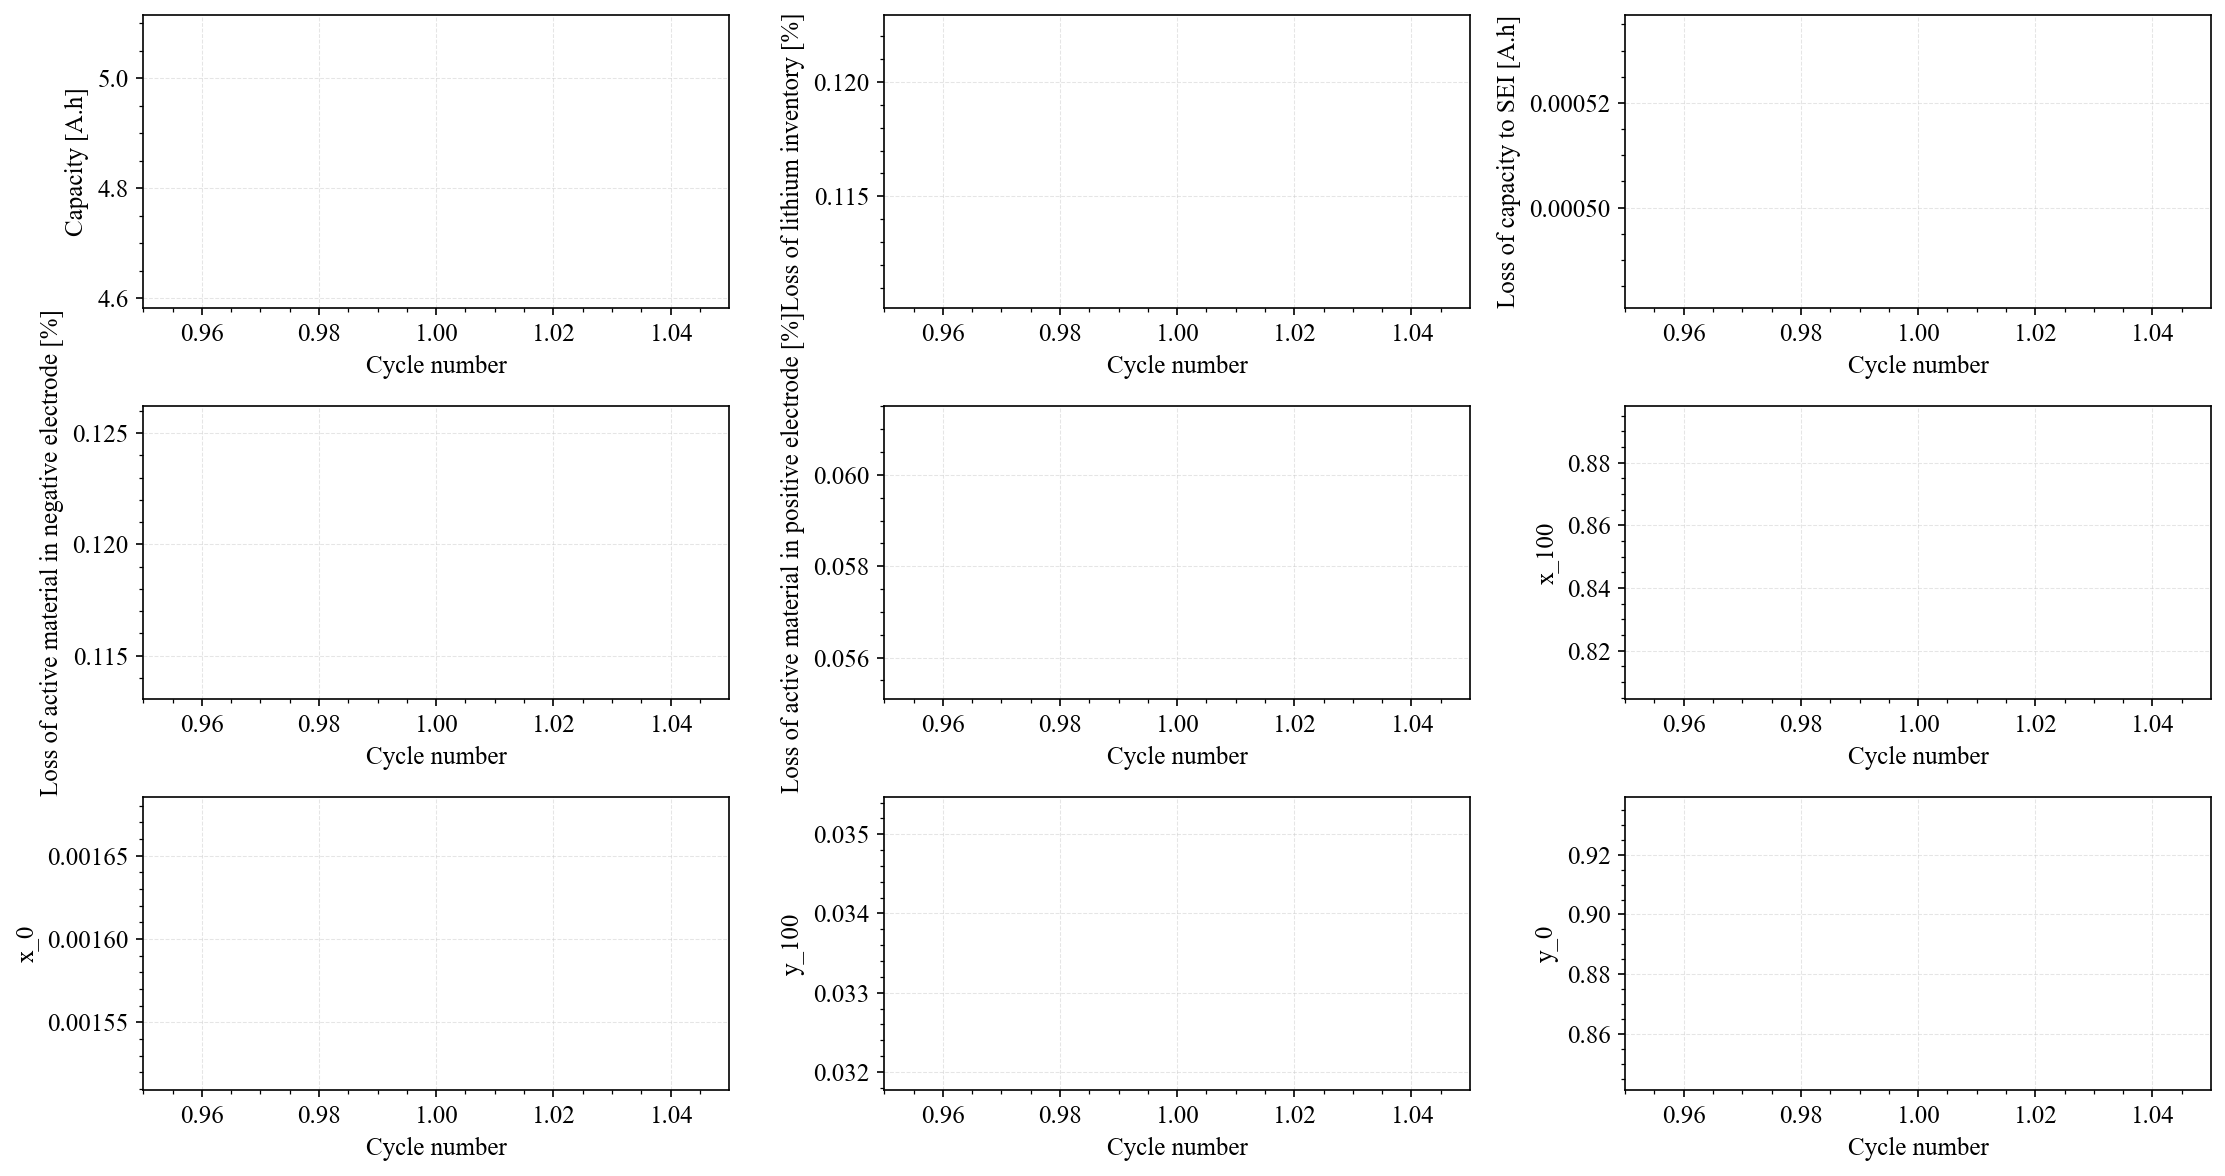

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [27]:
pybamm.plot_summary_variables(sol_long)

In [36]:
spm.variables.search("stress")

Negative particle surface radial stress
Negative particle surface radial stress [Pa]
Negative particle surface tangential stress
Negative particle surface tangential stress [Pa]
Positive particle surface radial stress
Positive particle surface radial stress [Pa]
Positive particle surface tangential stress
Positive particle surface tangential stress [Pa]
X-averaged negative particle surface radial stress
X-averaged negative particle surface radial stress [Pa]
X-averaged negative particle surface tangential stress
X-averaged negative particle surface tangential stress [Pa]
X-averaged positive particle surface radial stress
X-averaged positive particle surface radial stress [Pa]
X-averaged positive particle surface tangential stress
X-averaged positive particle surface tangential stress [Pa]


In [39]:
sim_long.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
        "Positive particle surface concentration [mol.m-3]",
        "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
#         "SEI thickness [m]",
#         "Loss of capacity to SEI [A.h]",
        "Negative electrode capacity [A.h]",
        "Positive electrode capacity [A.h]",
        "Discharge capacity [A.h]",
#         "X-averaged negative electrode active material volume fraction",
#         "X-averaged negative particle surface concentration [mol.m-3]",
#         "Loss of lithium to SEI on cracks [mol]",
        "Loss of lithium to lithium plating [mol]",
        "Loss of lithium to SEI [mol]",
#         "Total lithium lost [mol]",
#         "Total lithium in particles [mol]",
#         "Total lithium lost to side reactions [mol]",
        "Loss of lithium inventory [%]",
        "Time [s]",

        "X-averaged negative particle surface tangential stress",
        "X-averaged negative particle surface radial stress",
                
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=12.697231243877326, step=0.12697231243877327…

In [41]:
Tang_stress=sol_long["X-averaged negative particle surface tangential stress"].entries
# sol_long["Terminal voltage [V]"].entries
# sol_long.summary_variables["Total lithium lost to side reactions [mol]"]

# sol_long["Loss of lithium inventory [%]"].entries

In [43]:
TT=rainflow.extract_cycles(Tang_stress)
list(TT)

[(3.4751800651322754e-06, 5.581735021880503e-05, 1.0, 28, 29),
 (3.8852169626485404e-05, 5.415157647060964e-05, 1.0, 31, 41),
 (4.4671785384191316e-05, 5.894471329439753e-05, 1.0, 48, 55),
 (1.9914611512629433e-07, 6.773125795513091e-05, 1.0, 67, 68),
 (7.079526928820121e-06, 6.688942101549036e-05, 1.0, 71, 74),
 (3.9178453649022085e-06, 6.756960808179321e-05, 1.0, 80, 81),
 (2.8551753891790932e-05, 7.54640438347838e-05, 1.0, 61, 77),
 (3.1753577412266254e-06, 7.806731829094678e-05, 1.0, 94, 96),
 (1.3323304829317124e-05, 7.4995418141547e-05, 1.0, 103, 108),
 (2.2968247484572672e-05, 7.877326294634945e-05, 1.0, 99, 113),
 (4.515370342322845e-06, 3.088725241766344e-05, 1.0, 123, 127),
 (7.284710572291739e-05, 5.5242869860742936e-05, 1.0, 87, 164),
 (1.1400595126880006e-05, 7.831747095614697e-05, 1.0, 178, 182),
 (7.055499016965505e-05, 7.74997152463916e-05, 1.0, 173, 188),
 (1.9687915986273894e-05, 0.00020407967441413334, 1.0, 233, 240),
 (7.331963629677796e-05, 0.00019730228580699428, 

In [ ]:
sol_long.save("experiment14_jan27")

In [ ]:
import pickle
file=open(r"D:\Saved pickle\experiment13_jan27","rb")
sol_long=pickle.load(file)

In [ ]:
type(sol_long.summary_variables[list(sol_long.summary_variables.keys())[1]])

In [ ]:
# mdic={}
# for i in range (1):
# # range(len(sol_long.summary_variables)):
# #     stringing=''.join([list(sol_long.summary_variables.keys())[i]])
#     mdic={f"{i}": sol_long.summary_variables[list(sol_long.summary_variables.keys())[i]]}
# savemat("summary",mdic)


In [31]:
sol_long=sol_long223
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries

# ECM_res=sol_long.summary_variables["Local ECM resistance [Ohm]"]

# ECM_whole_res=sol_long["Local ECM resistance [Ohm]"].entries
# ECM_sum_res=sol_long.summary_variables["Local ECM resistance [Ohm]"]
# ECM_sum_res_change=sol_long.summary_variables['Change in local ECM resistance [Ohm]']

cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,



# exp = 30e6*sol_0["Cell thickness change [m]"].entries
# exp_n = 30e6*sol_0["Negative Electrode thickness change [m]"].entries
# exp_p = 30e6*sol_0["Positive Electrode thickness change [m]"].entries
# ee_p = sol_0["X-averaged positive electrode porosity"].entries
# ee_n = sol_0["X-averaged negative electrode porosity"].entries
# ee_s = sol_0["X-averaged separator porosity"].entries
# j_n = sol_0["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
# j_p = sol_0["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

# x = sol_0["x [m]"].entries
# c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries

In [32]:
ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
    
       }
savemat("experiment223_Jun27.mat",mdic)

NameError: name 'sol_long13' is not defined

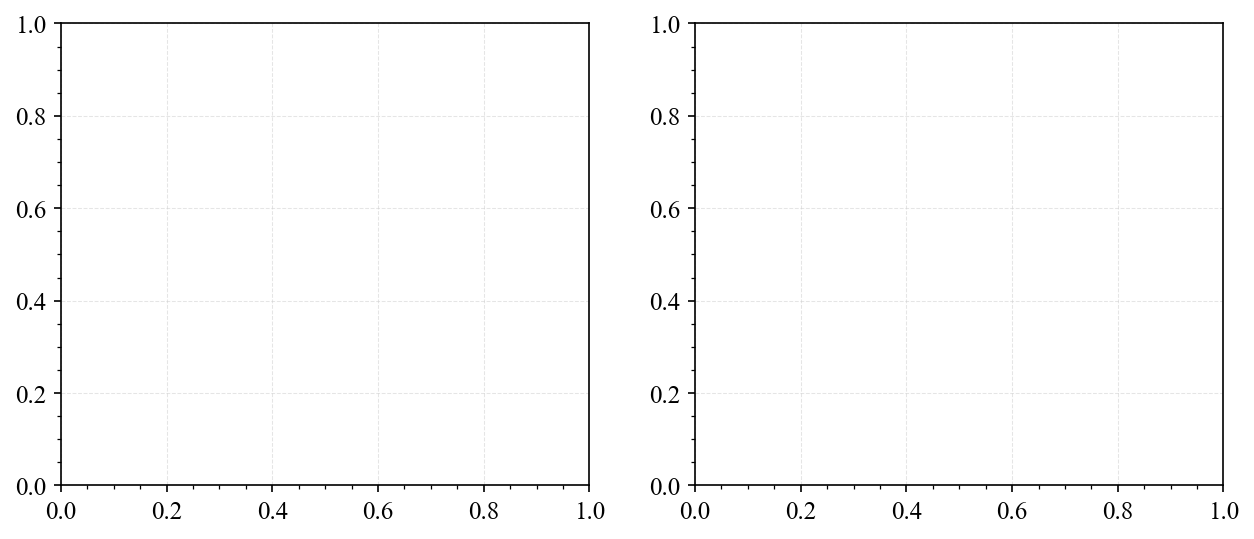

In [33]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Positive electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Positive electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Positive electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")
ax.set_title("Positive electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("y")

ax = axes.flat[1]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Negative electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Negative electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Negative electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")

ax.set_title("Negative electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("x")

In [ ]:
# print(x100)

In [ ]:
# import csv
# with open(r"F:\Git Hub rep\CRC\neew\PyBaMM\Untitled Folder\whatever.csv", 'w') as f:
#     # create the csv writer
#     writer = csv.writer(f)

# write a row to the csv file
# i=1
# for lines in sol_long.all_summary_variables:
# #     writer.writerow(words)
#     i=i+1
#     savemat(f'{i:02d}', lines)


In [ ]:
type(x100)

In [ ]:
sol_long.variables.search("loss")

In [ ]:
# plt.plot(sol_long["Time [s]"].entries[1:15133], sol_long["Current [A]"].entries[1:15133])

In [ ]:
# plt.plot(sol_long["Time [s]"].entries[1:15133], sol_long["Terminal voltage [V]"].entries[1:15133])

In [ ]:
 plt.plot(sol_long["Time [s]"].entries, 1-sol_long["Discharge capacity [A.h]"].entries/5)

In [ ]:
# plt.plot(cycle_num,C_Neg/5.9)

In [ ]:
# plt.plot(cycle_num,C_pos/5.68)

In [ ]:
# plt.plot(cycle_num,LLI)

In [ ]:
# plt.plot(t,I)

In [ ]:
sol_long.summary_variables 

In [ ]:
spm.param.n.prim

In [ ]:
# experiment3 = pybamm.Experiment( #GM_ DRC-DRC
#     [
#         ("Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for .6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*700,
#     drive_cycles={"US06_OEM1": drive_cycle_OEM1},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment4 = pybamm.Experiment( #Gm-RCRC
#     [
#         ("Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 3.1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*1000,
#     drive_cycles={"US06_OEM1": drive_cycle_OEM1},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment = pybamm.Experiment( # defult D.C. DRC-DRC *1.25
#     [
#         ("Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for .9 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 1.9 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*700,
#     drive_cycles={"US06": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment2 = pybamm.Experiment( #lab cycling
#     [
#         ("Discharge at "+c_rate_d+dis_set,
#          "Rest for 5 min",
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50")
#     ] *2,
#     # ] *40,
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

## GM_DCRDCR
# experiment5 = pybamm.Experiment( # defult D.C. RC-RC
#     [
#         ("Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.8 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 3.7 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*1000,
#     drive_cycles={"US06": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment7 = pybamm.Experiment( #Gm-CRCR
#     [
#         ("Run US06_GM_5Ah (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs        
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06_GM_5Ah (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#          "Hold at 4.2V for 3.1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 20 minutes",     
#         )

#     ]*1000,
#     drive_cycles={"US06_GM_5Ah": drive_cycle2},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment8 = pybamm.Experiment( # defult D.C. CR-CR
#     [
#         ("Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.8 hours",  # needs fixing : last step +this step =2.5 hrs         
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#          "Hold at 4.2V for 3.7 hours",  # needs fixing : last step +this step =4.5 hrs         
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Rest for 20 minutes",     
#         )

#     ]*1000,
#     drive_cycles={"US06": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# experiment10 = pybamm.Experiment( # defult D.C. CR-CR
#     [
#         (
#          "Rest for 12 hours",     
#         )

#     ]*1000,
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment6 = pybamm.Experiment( # defult D.C. DRC-DRC *1.25 with power
#     [
#         ("Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          #"Discharge at C/4 for 1 hours", # should be P/4 
#          "Discharge at 5.25 W for 1 hours", # ~~~ 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for .75 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06 (A) for 1 hours",
#          "Rest for 5 minutes",
#          #"Discharge at C/4 for 1 hours", # should be P/4 
#          "Discharge at 5.25 W for 1 hours", # ~~~
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 1.75 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*520,
#     drive_cycles={"US06": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )